# **Tell Me What You Want, I'll Tell You What You Like**

In this file, we try to use the first clustering approach (the basic version) (random exploration)

## DOcplex Python API installation

First, we install the docplex python API which we will use for modelling our problem and solving it. (Then, we will not have problem size error)

In [1]:
import sys
try:
    import docplex.mp
except:
    if hasattr(sys, 'real_prefix'):
        !pip install docplex -q
        print("!pip install docplex -q...")
    else:
        !pip install --user docplex -q
        print("!pip install --user docplex -q...")
        
print("End of the intallation of python API...")

End of the intallation of python API...


## Main code

In [2]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [3]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm

In [4]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20



# The number of solutions that we will have in the solver after the first iteration
k_k = 10

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [5]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, tasks = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 3860
Le max de list_obj est 4104
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x000002209BABB240>, <docplex.cp.solution.CpoSolveResult object at 0x000002209BABB140>], [<docplex.cp.solution.CpoSolveResult object at 0x000002209BABB440>, <docplex.cp.solution.CpoSolveResult object at 0x000002209BABB740

In [6]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, tasks = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # --------- Add the constraints considering the clustering
    if it > 1:
        model, variables = solver.create_constraints(model, n, m, list_min_obj_global[it-1], T_machine)
    else :
        model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
    
    #------------------ Layers creation 
    # layers = cl.create_layers(list_equal, matrix)
    layers = cl.create_layers_fixed(list_layers)
    print(len(layers))
    # print(len(layers[i]) for i in range (len(layers)))
        #------------------ Définition du nombre de clusters par layer (liste des nb de clusters par layer)
    nb_clusters = fm.choose_best_clusters(layers)

    default_value_rayon = 5 

    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        print("-------------- Layer", l, "-----------------")
        print("Number of clusters :", k)
        print("Number of solutions :", len(data))

        if l > 0:
            #------------------ If there is only one solution in the layer, we add a constraint to the model
            if(len(data)==0):
                continue
            elif (len(data) == 1):
                solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > default_value_rayon + l)
                continue
            else :
            #------------------ Get the average of each cluster
                k, avg, labels = fm.average_computation(data, k)

            #------------------ Get the solutions which is the closest to the average of each cluster
                the_ones = fm.solution_average(k, data, labels, avg)
                
            #------------------ Ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure au rayon du cluster + l
                #------------------ Liste des solutions des clusters de la layer l

                for i in range(k):
                    sol_cluster=[]
                    for j in range(len(data)):
                        if labels[j]==i:
                            sol_cluster.append(data[j])
                #------------------ Ajout des contraintes
                    solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >  fm.rayon_cluster(the_ones[i], sol_cluster) + l)
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)+user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)


#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)

    it += 1


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Clustering ...
5
-------------- Layer 0 -----------------
Number of clusters : 2
Number of solutions : 2
-------------- Layer 1 -----------------
Number of clusters : 3
Number of solutions : 4
-------------- Layer 2 -----------------
Number of clusters : 2
Number of solutions : 2
-------------- Layer 3 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 4 -----------------
Number of clusters : 1
Number of solutions : 1

Solving the model...
The number of solutions generated is : 10
Objective function : [3860, 3863]
Model solved !

Classing solutions...
Le min de list_obj est 3860
Le max de list_obj est 4109
Solutions classed !

Creating preferences...
Preferences created !
Il y a 20

[3860, 3863, 3943, 3913, 3866, 3869, 3872, 3875, 3878, 3881, 3884, 3887, 3890, 3893, 3896, 3899, 3902, 3905, 3908, 3911, 3914]


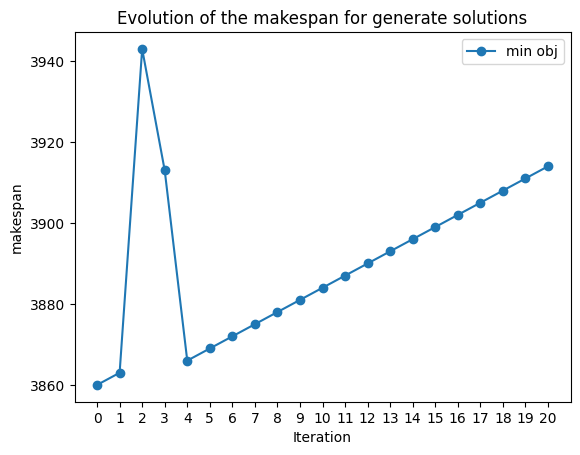

In [7]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860, 3860]


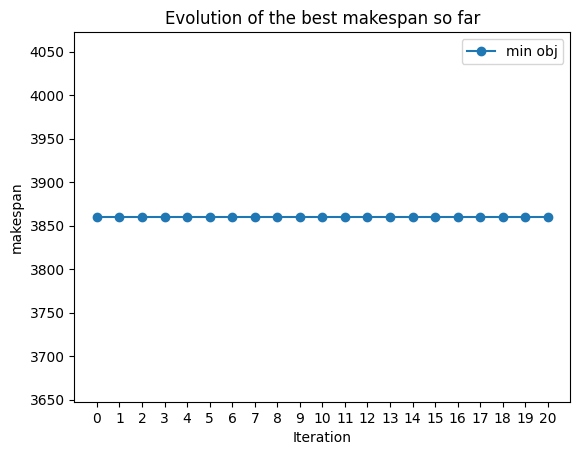

In [8]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

210


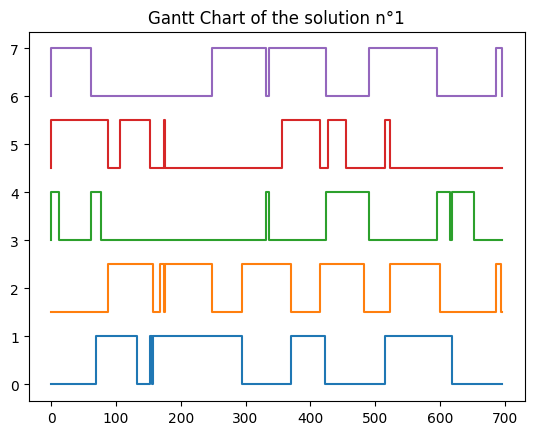

Makespan of the solution n°1 : 696
Regularity of the solution n°1 : 3164
Objective function of the solution n°1 : 2202144


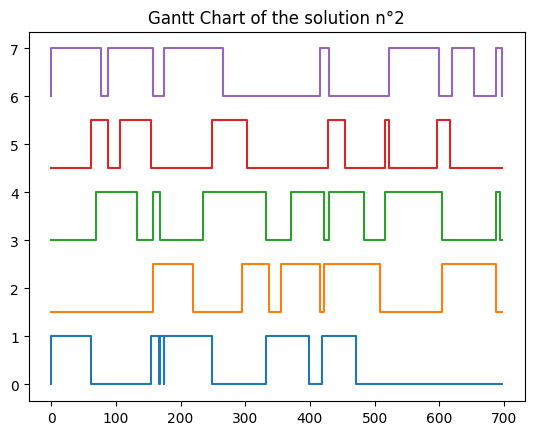

Makespan of the solution n°2 : 697
Regularity of the solution n°2 : 3166
Objective function of the solution n°2 : 2206702


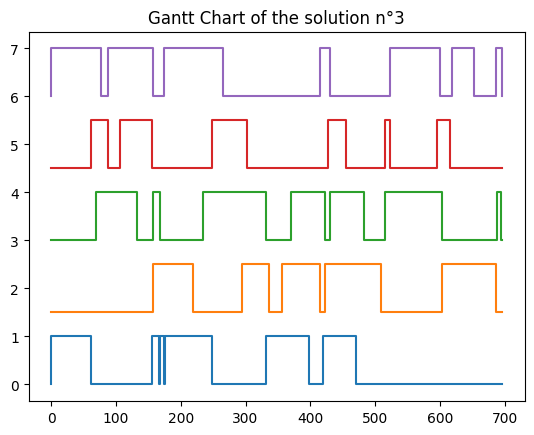

Makespan of the solution n°3 : 696
Regularity of the solution n°3 : 3168
Objective function of the solution n°3 : 2204928


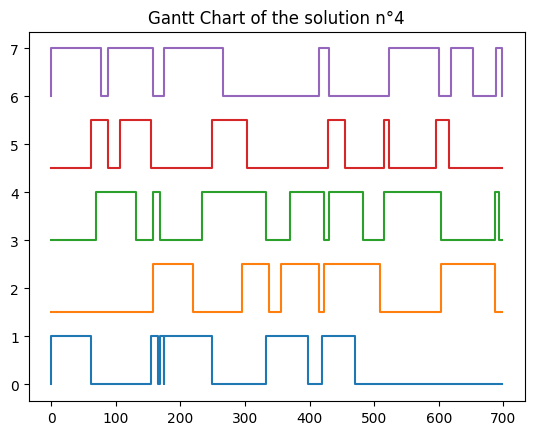

Makespan of the solution n°4 : 698
Regularity of the solution n°4 : 3168
Objective function of the solution n°4 : 2211264


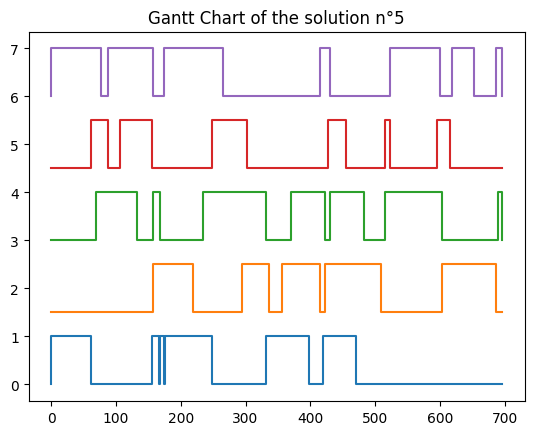

Makespan of the solution n°5 : 696
Regularity of the solution n°5 : 3172
Objective function of the solution n°5 : 2207712


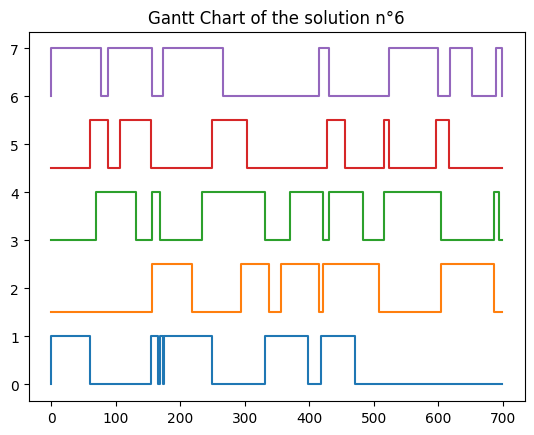

Makespan of the solution n°6 : 699
Regularity of the solution n°6 : 3170
Objective function of the solution n°6 : 2215830


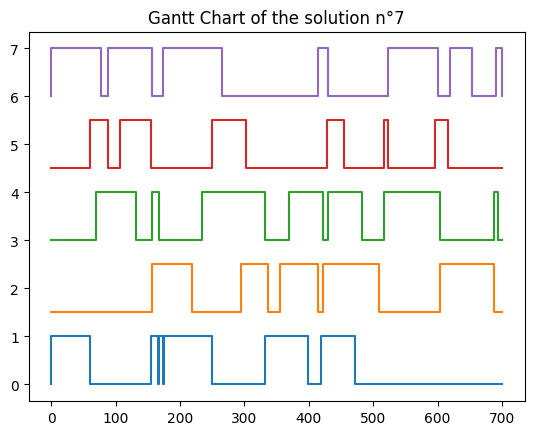

Makespan of the solution n°7 : 700
Regularity of the solution n°7 : 3172
Objective function of the solution n°7 : 2220400


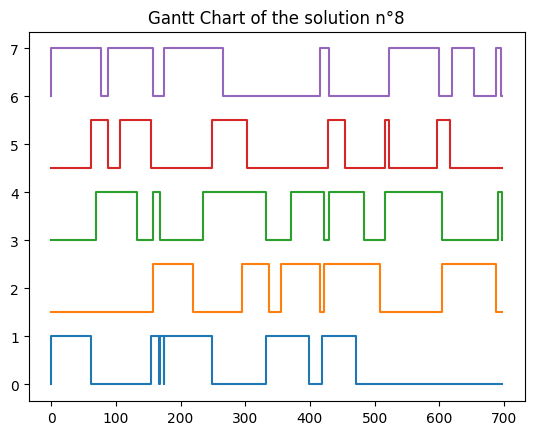

Makespan of the solution n°8 : 697
Regularity of the solution n°8 : 3176
Objective function of the solution n°8 : 2213672


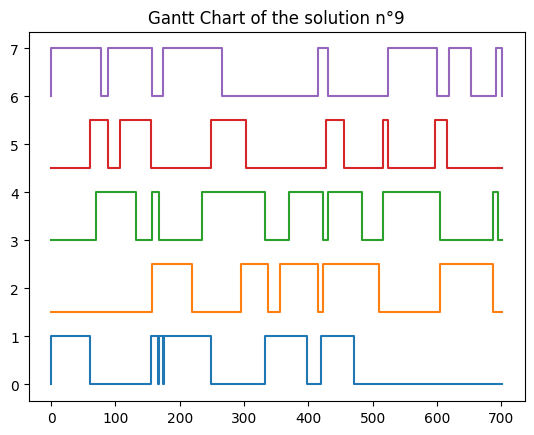

Makespan of the solution n°9 : 701
Regularity of the solution n°9 : 3174
Objective function of the solution n°9 : 2224974


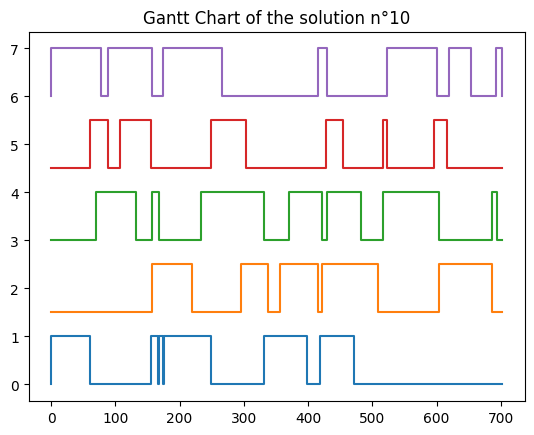

Makespan of the solution n°10 : 702
Regularity of the solution n°10 : 3176
Objective function of the solution n°10 : 2229552


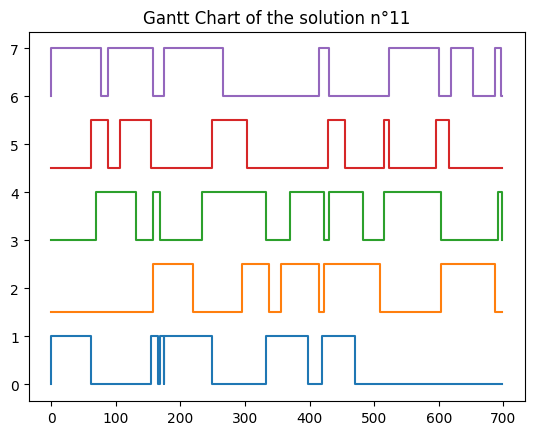

Makespan of the solution n°11 : 698
Regularity of the solution n°11 : 3180
Objective function of the solution n°11 : 2219640


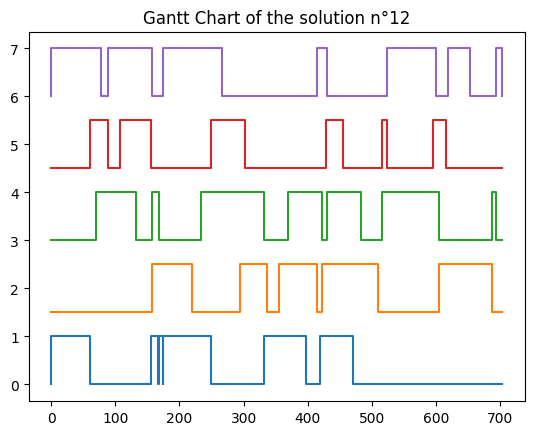

Makespan of the solution n°12 : 703
Regularity of the solution n°12 : 3178
Objective function of the solution n°12 : 2234134


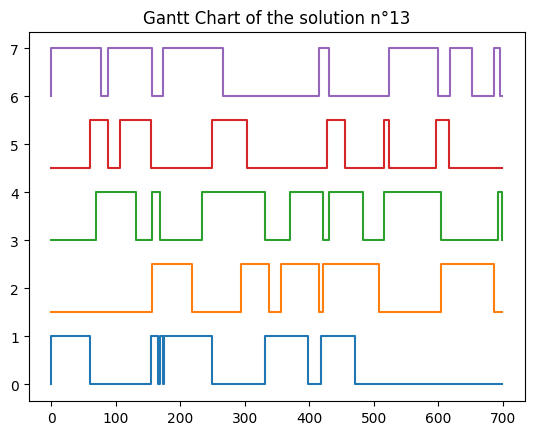

Makespan of the solution n°13 : 699
Regularity of the solution n°13 : 3184
Objective function of the solution n°13 : 2225616


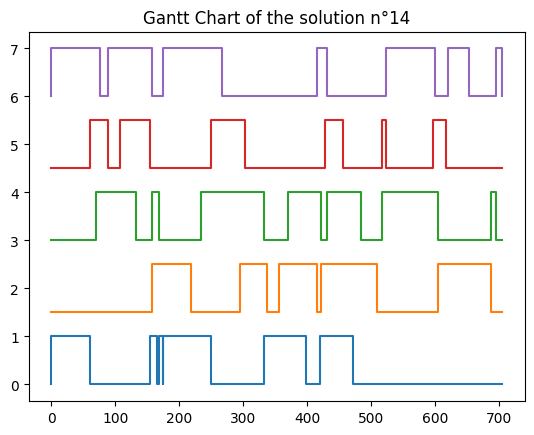

Makespan of the solution n°14 : 704
Regularity of the solution n°14 : 3180
Objective function of the solution n°14 : 2238720


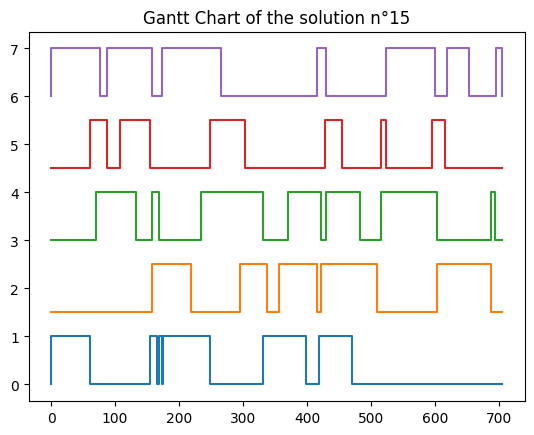

Makespan of the solution n°15 : 705
Regularity of the solution n°15 : 3182
Objective function of the solution n°15 : 2243310


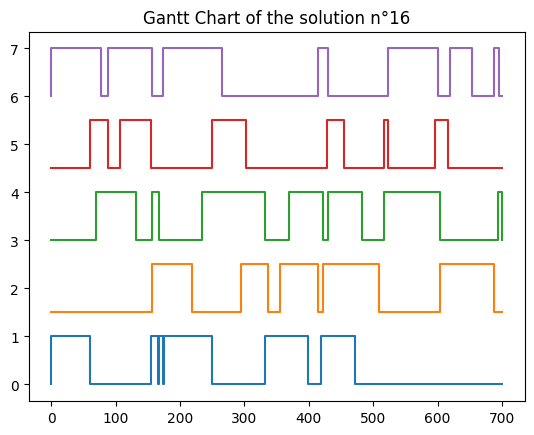

Makespan of the solution n°16 : 700
Regularity of the solution n°16 : 3188
Objective function of the solution n°16 : 2231600


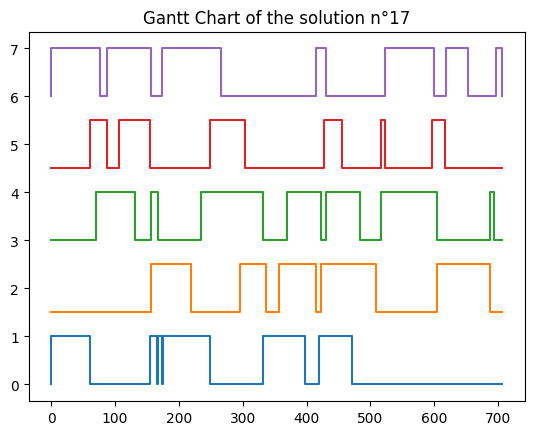

Makespan of the solution n°17 : 706
Regularity of the solution n°17 : 3184
Objective function of the solution n°17 : 2247904


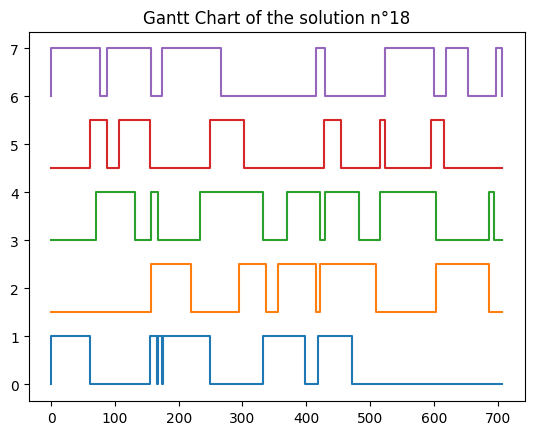

Makespan of the solution n°18 : 707
Regularity of the solution n°18 : 3186
Objective function of the solution n°18 : 2252502


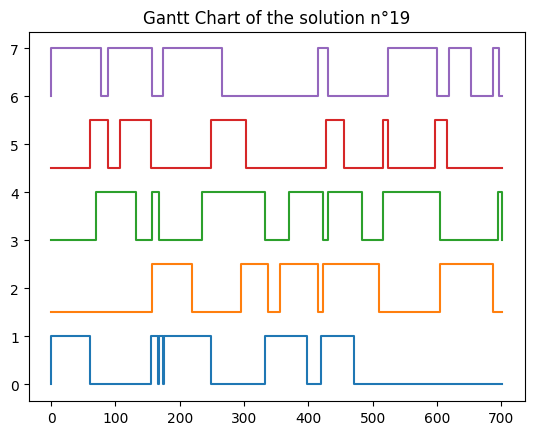

Makespan of the solution n°19 : 701
Regularity of the solution n°19 : 3192
Objective function of the solution n°19 : 2237592


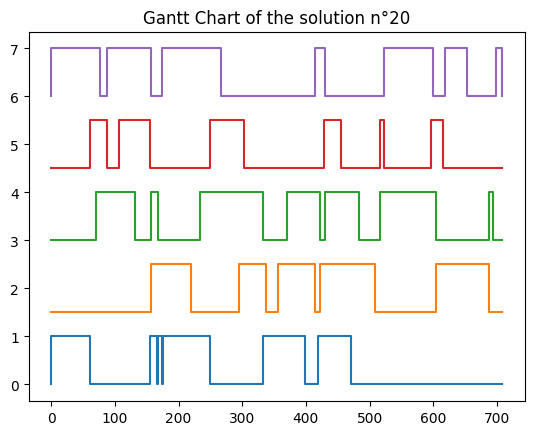

Makespan of the solution n°20 : 708
Regularity of the solution n°20 : 3188
Objective function of the solution n°20 : 2257104


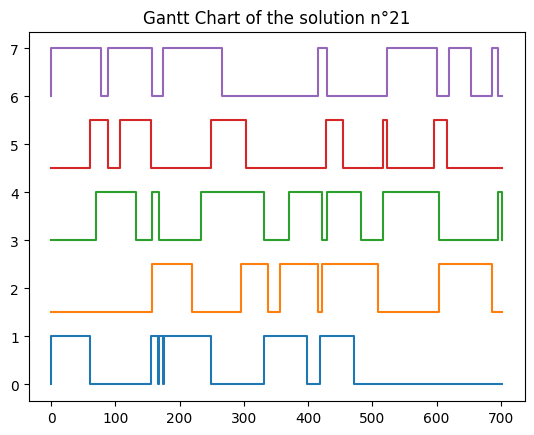

Makespan of the solution n°21 : 702
Regularity of the solution n°21 : 3196
Objective function of the solution n°21 : 2243592


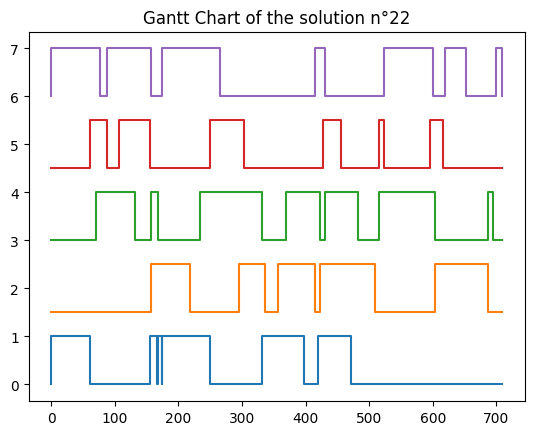

Makespan of the solution n°22 : 709
Regularity of the solution n°22 : 3190
Objective function of the solution n°22 : 2261710


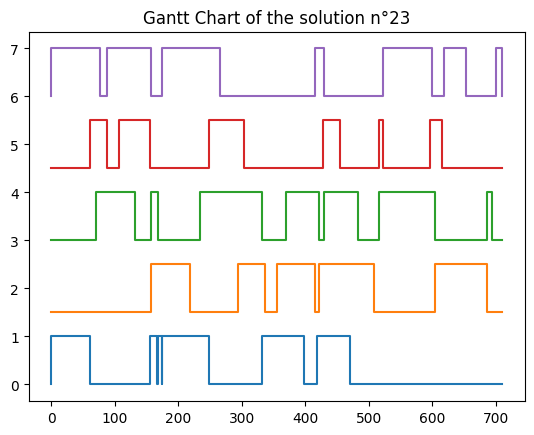

Makespan of the solution n°23 : 710
Regularity of the solution n°23 : 3192
Objective function of the solution n°23 : 2266320


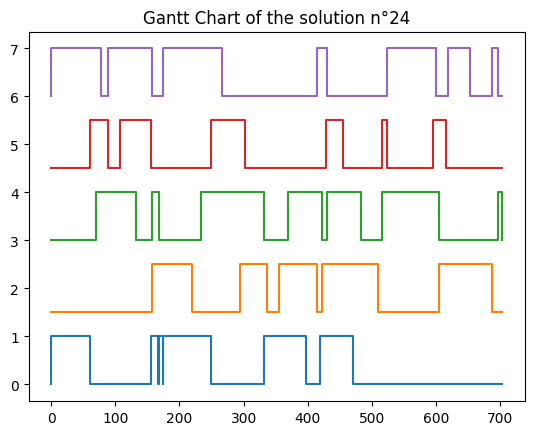

Makespan of the solution n°24 : 703
Regularity of the solution n°24 : 3200
Objective function of the solution n°24 : 2249600


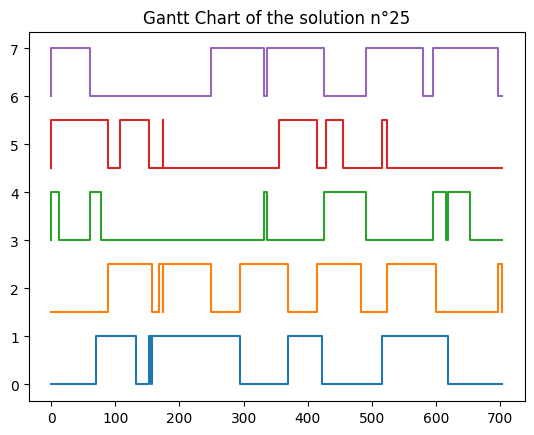

Makespan of the solution n°25 : 703
Regularity of the solution n°25 : 3200
Objective function of the solution n°25 : 2249600


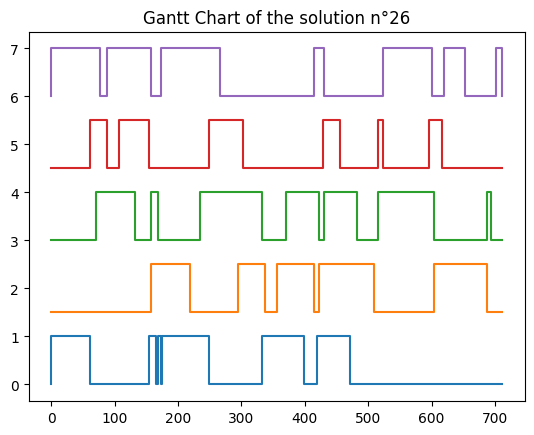

Makespan of the solution n°26 : 711
Regularity of the solution n°26 : 3194
Objective function of the solution n°26 : 2270934


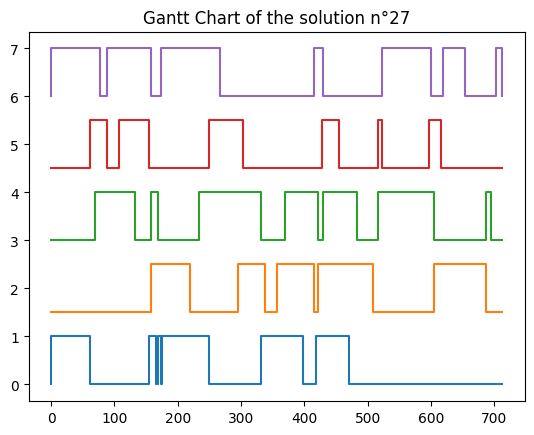

Makespan of the solution n°27 : 712
Regularity of the solution n°27 : 3196
Objective function of the solution n°27 : 2275552


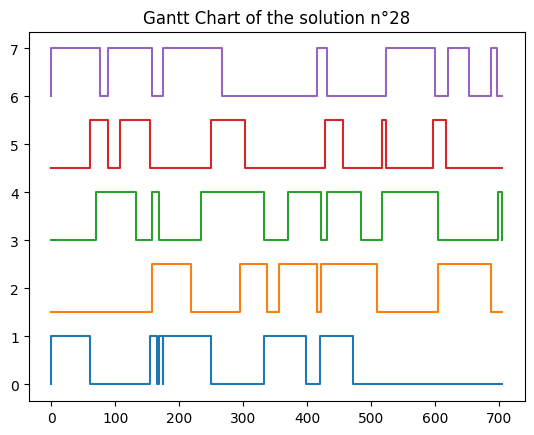

Makespan of the solution n°28 : 704
Regularity of the solution n°28 : 3204
Objective function of the solution n°28 : 2255616


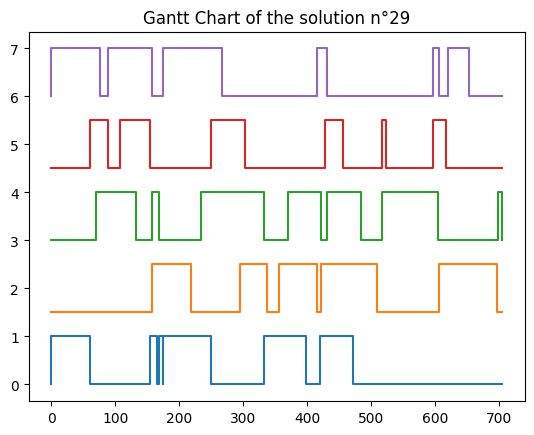

Makespan of the solution n°29 : 704
Regularity of the solution n°29 : 3204
Objective function of the solution n°29 : 2255616


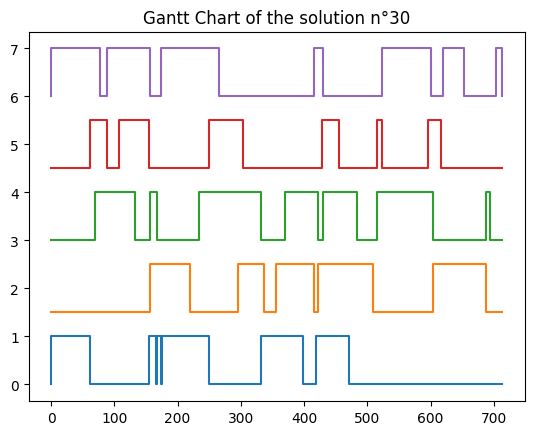

Makespan of the solution n°30 : 713
Regularity of the solution n°30 : 3198
Objective function of the solution n°30 : 2280174


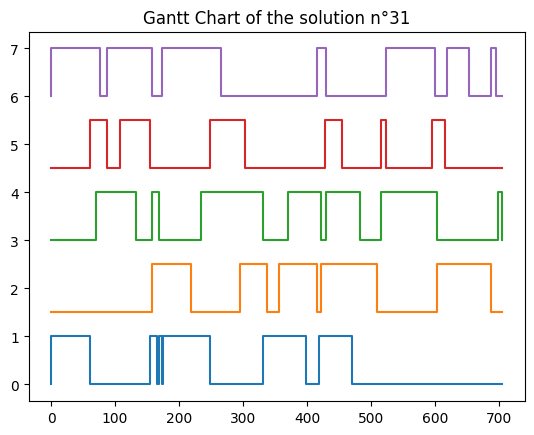

Makespan of the solution n°31 : 705
Regularity of the solution n°31 : 3208
Objective function of the solution n°31 : 2261640


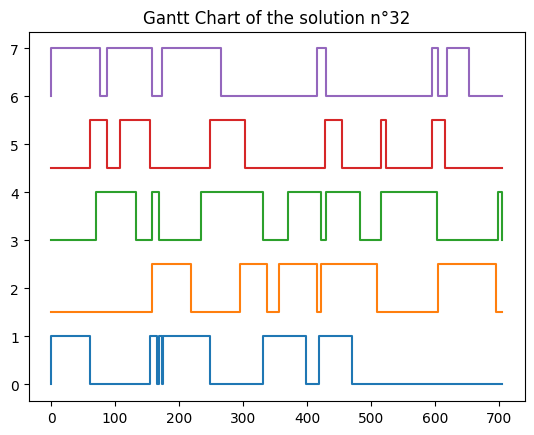

Makespan of the solution n°32 : 705
Regularity of the solution n°32 : 3208
Objective function of the solution n°32 : 2261640


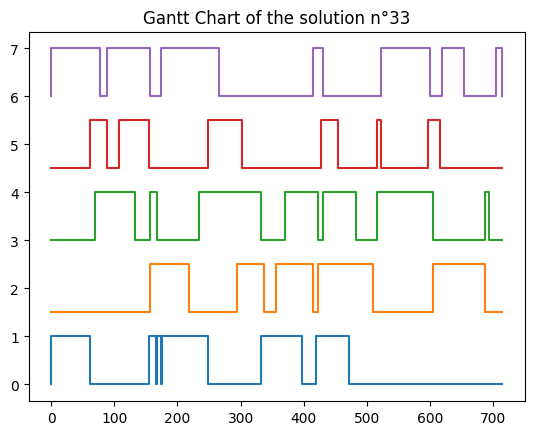

Makespan of the solution n°33 : 714
Regularity of the solution n°33 : 3200
Objective function of the solution n°33 : 2284800


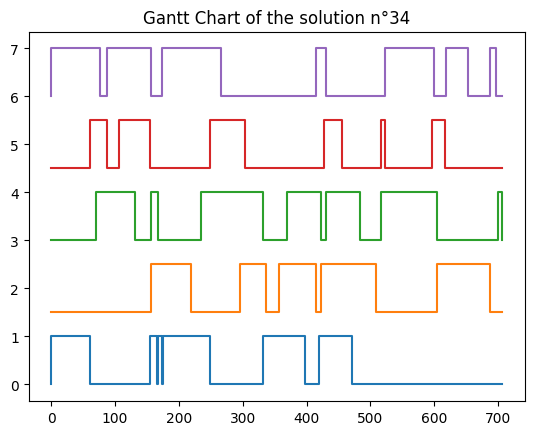

Makespan of the solution n°34 : 706
Regularity of the solution n°34 : 3212
Objective function of the solution n°34 : 2267672


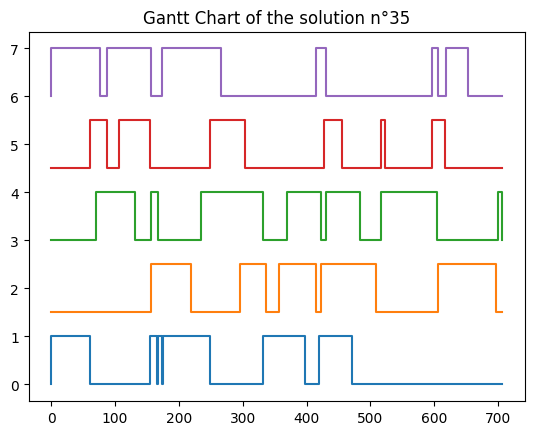

Makespan of the solution n°35 : 706
Regularity of the solution n°35 : 3212
Objective function of the solution n°35 : 2267672


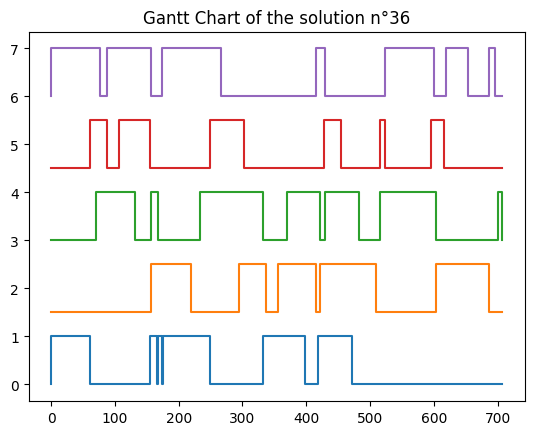

Makespan of the solution n°36 : 707
Regularity of the solution n°36 : 3216
Objective function of the solution n°36 : 2273712


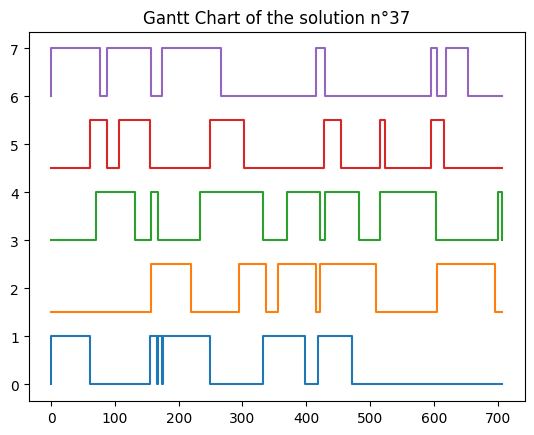

Makespan of the solution n°37 : 707
Regularity of the solution n°37 : 3216
Objective function of the solution n°37 : 2273712


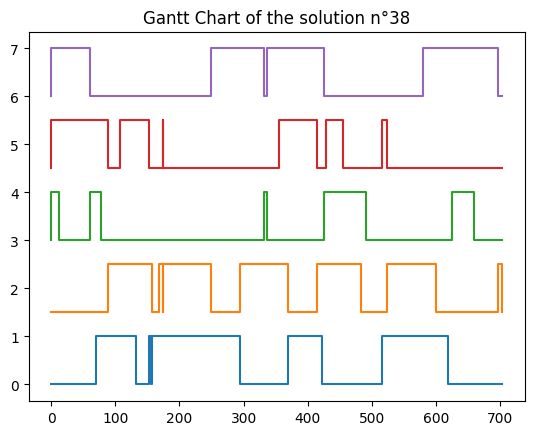

Makespan of the solution n°38 : 703
Regularity of the solution n°38 : 3224
Objective function of the solution n°38 : 2266472


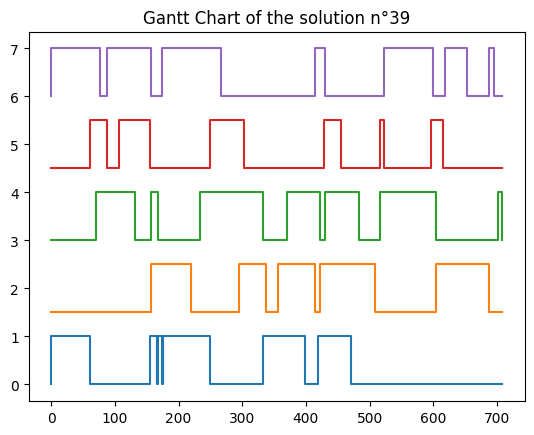

Makespan of the solution n°39 : 708
Regularity of the solution n°39 : 3220
Objective function of the solution n°39 : 2279760


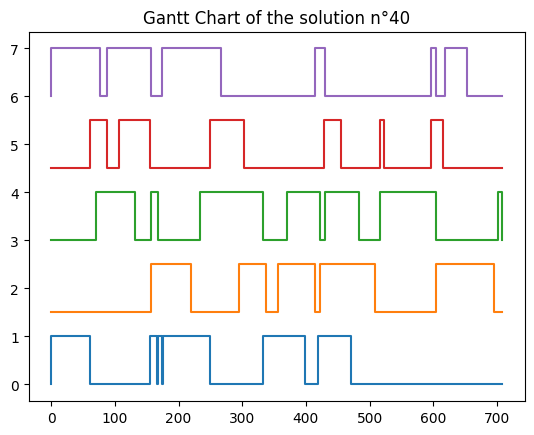

Makespan of the solution n°40 : 708
Regularity of the solution n°40 : 3220
Objective function of the solution n°40 : 2279760


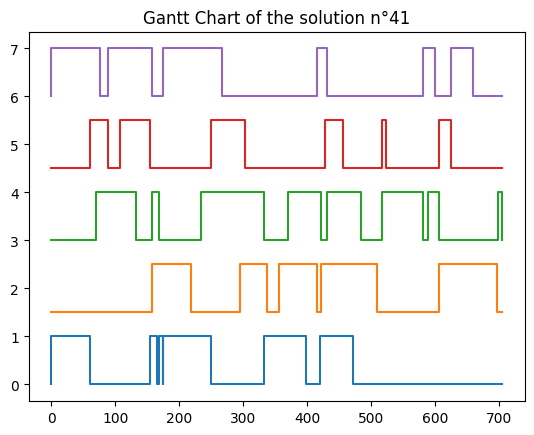

Makespan of the solution n°41 : 704
Regularity of the solution n°41 : 3228
Objective function of the solution n°41 : 2272512


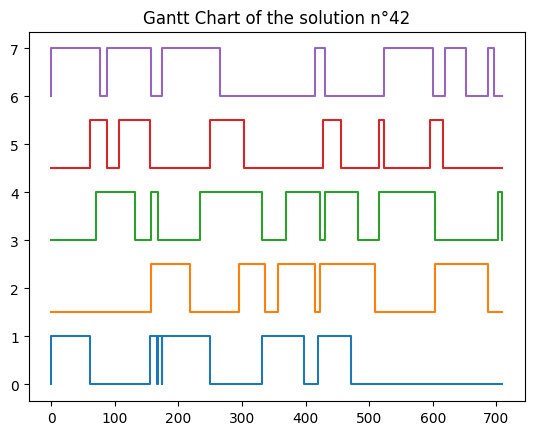

Makespan of the solution n°42 : 709
Regularity of the solution n°42 : 3224
Objective function of the solution n°42 : 2285816


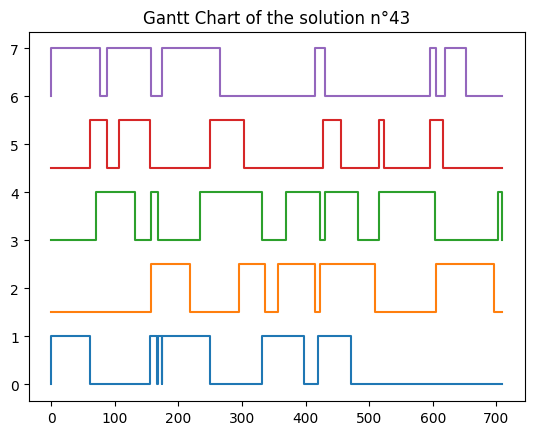

Makespan of the solution n°43 : 709
Regularity of the solution n°43 : 3224
Objective function of the solution n°43 : 2285816


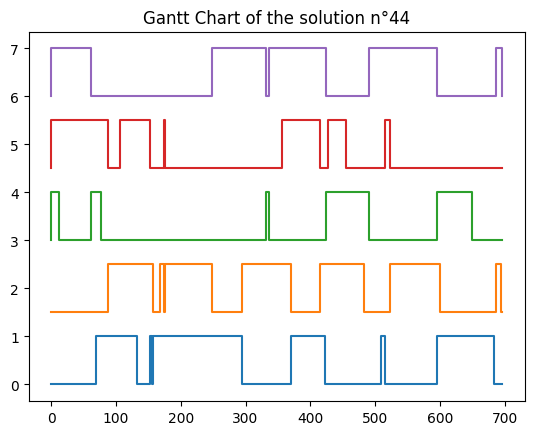

Makespan of the solution n°44 : 696
Regularity of the solution n°44 : 3238
Objective function of the solution n°44 : 2253648


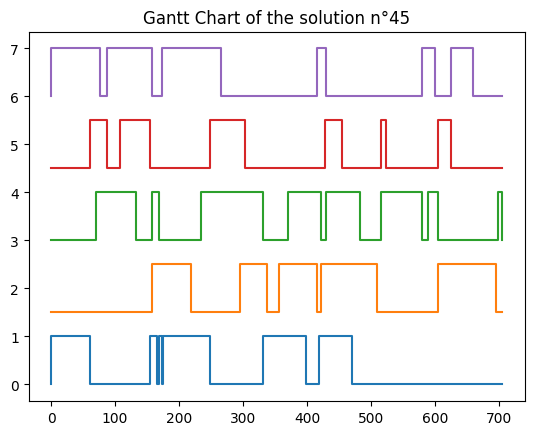

Makespan of the solution n°45 : 705
Regularity of the solution n°45 : 3232
Objective function of the solution n°45 : 2278560


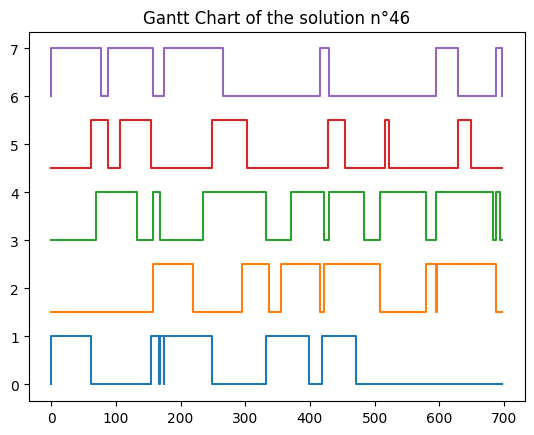

Makespan of the solution n°46 : 697
Regularity of the solution n°46 : 3240
Objective function of the solution n°46 : 2258280


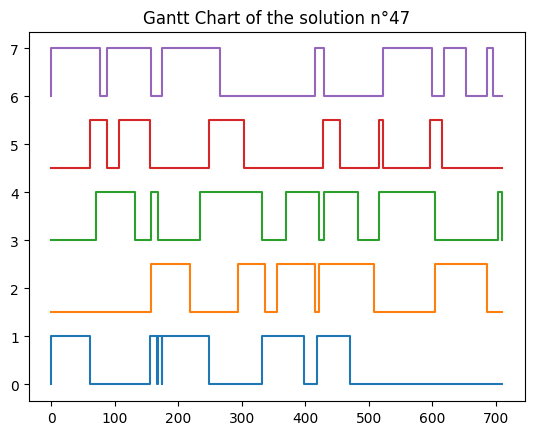

Makespan of the solution n°47 : 710
Regularity of the solution n°47 : 3228
Objective function of the solution n°47 : 2291880


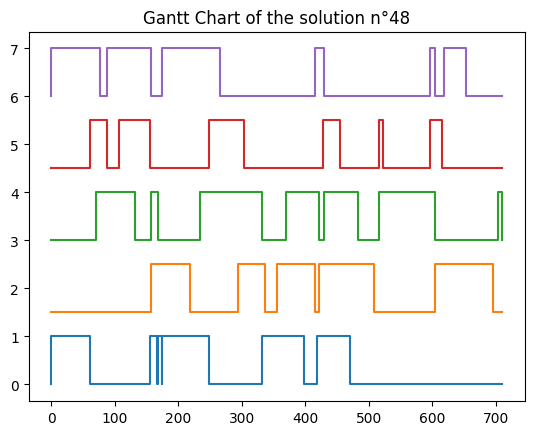

Makespan of the solution n°48 : 710
Regularity of the solution n°48 : 3228
Objective function of the solution n°48 : 2291880


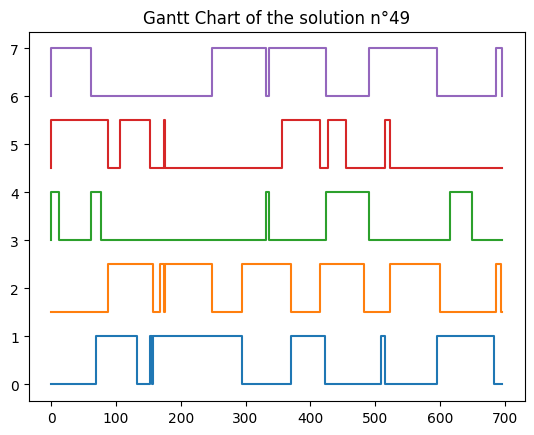

Makespan of the solution n°49 : 696
Regularity of the solution n°49 : 3242
Objective function of the solution n°49 : 2256432


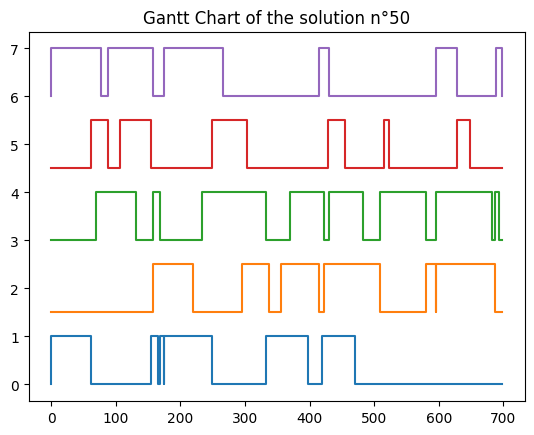

Makespan of the solution n°50 : 698
Regularity of the solution n°50 : 3242
Objective function of the solution n°50 : 2262916


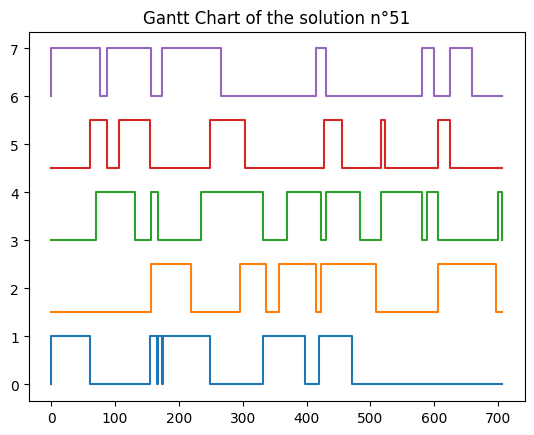

Makespan of the solution n°51 : 706
Regularity of the solution n°51 : 3236
Objective function of the solution n°51 : 2284616


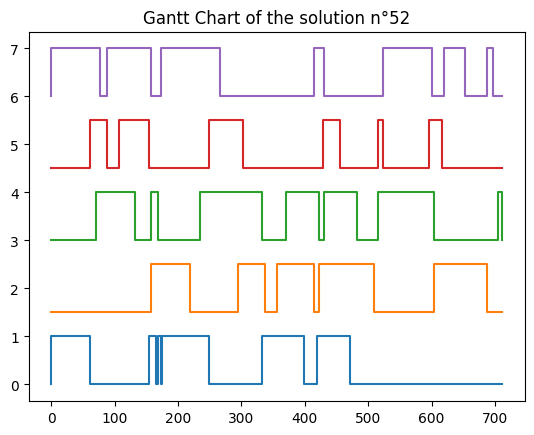

Makespan of the solution n°52 : 711
Regularity of the solution n°52 : 3232
Objective function of the solution n°52 : 2297952


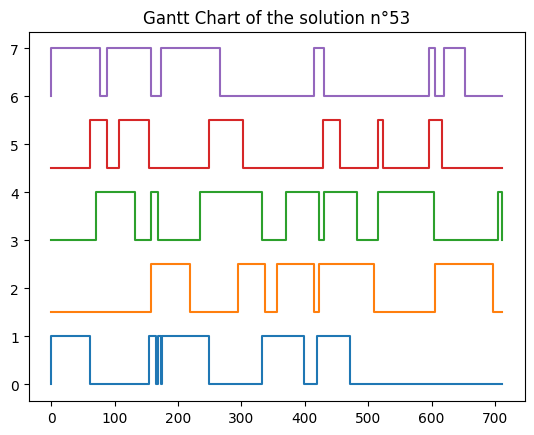

Makespan of the solution n°53 : 711
Regularity of the solution n°53 : 3232
Objective function of the solution n°53 : 2297952


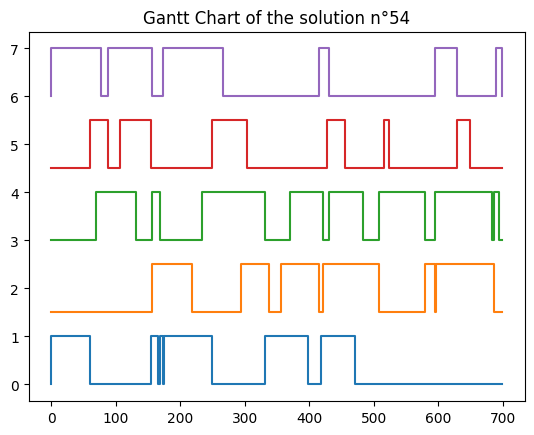

Makespan of the solution n°54 : 699
Regularity of the solution n°54 : 3244
Objective function of the solution n°54 : 2267556


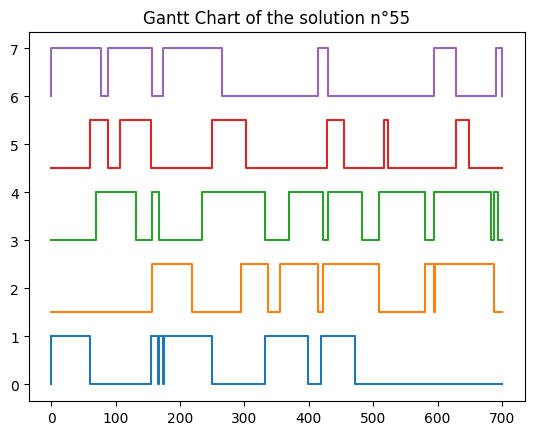

Makespan of the solution n°55 : 700
Regularity of the solution n°55 : 3246
Objective function of the solution n°55 : 2272200


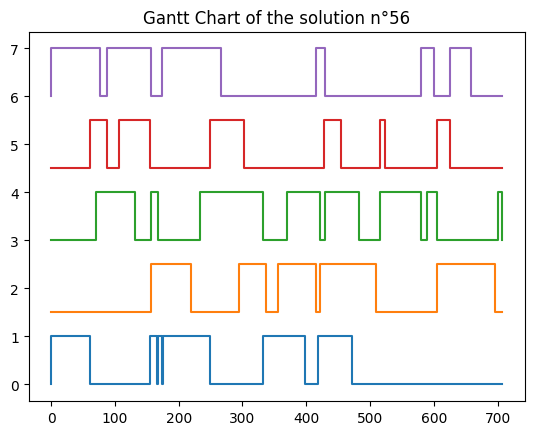

Makespan of the solution n°56 : 707
Regularity of the solution n°56 : 3240
Objective function of the solution n°56 : 2290680


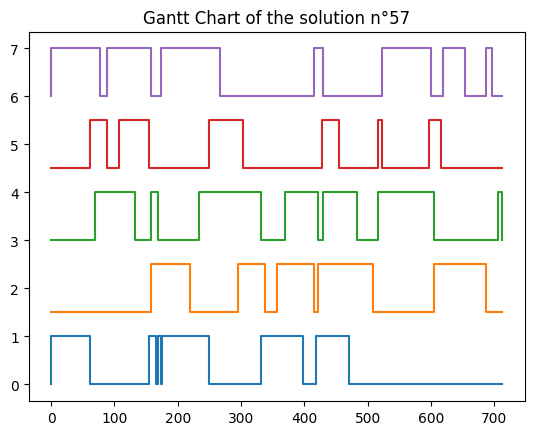

Makespan of the solution n°57 : 712
Regularity of the solution n°57 : 3236
Objective function of the solution n°57 : 2304032


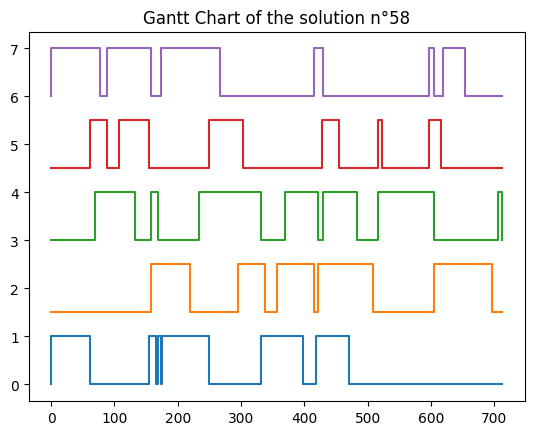

Makespan of the solution n°58 : 712
Regularity of the solution n°58 : 3236
Objective function of the solution n°58 : 2304032


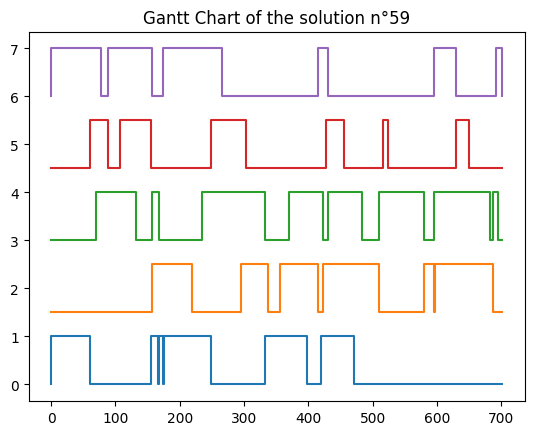

Makespan of the solution n°59 : 701
Regularity of the solution n°59 : 3248
Objective function of the solution n°59 : 2276848


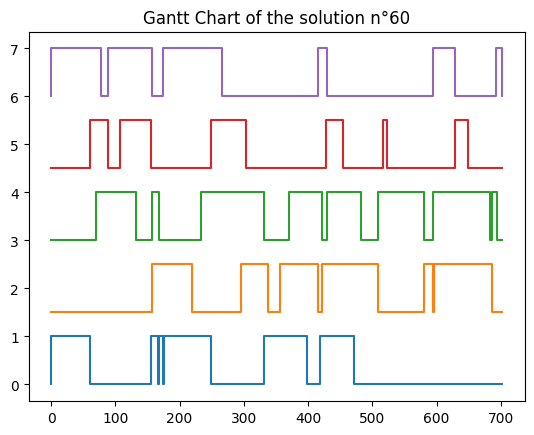

Makespan of the solution n°60 : 702
Regularity of the solution n°60 : 3250
Objective function of the solution n°60 : 2281500


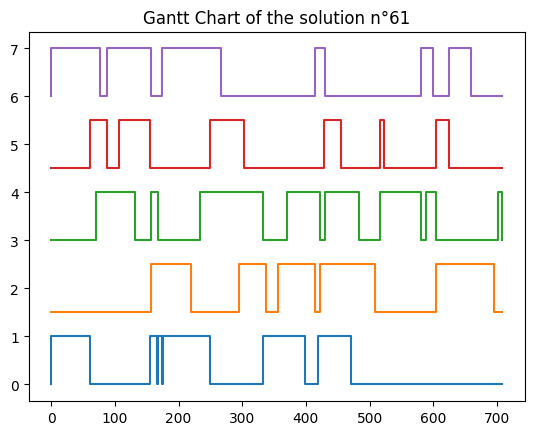

Makespan of the solution n°61 : 708
Regularity of the solution n°61 : 3244
Objective function of the solution n°61 : 2296752


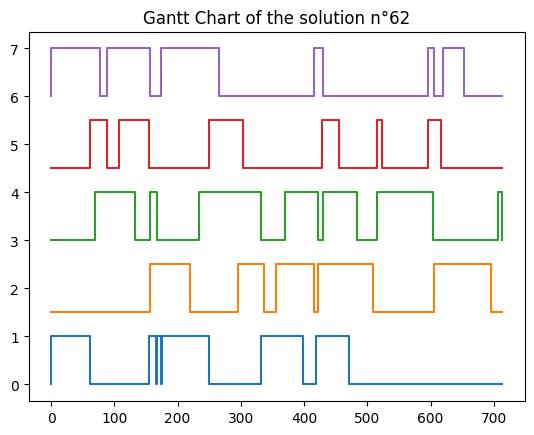

Makespan of the solution n°62 : 713
Regularity of the solution n°62 : 3240
Objective function of the solution n°62 : 2310120


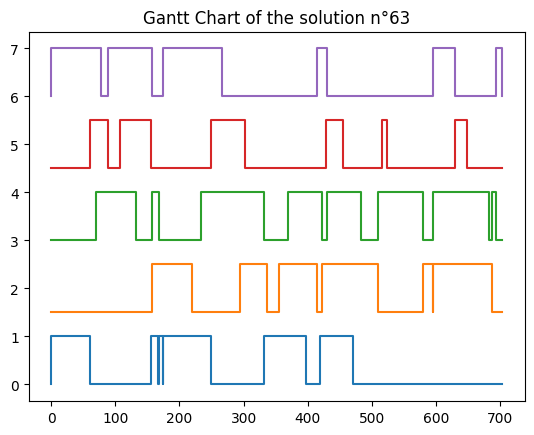

Makespan of the solution n°63 : 703
Regularity of the solution n°63 : 3252
Objective function of the solution n°63 : 2286156


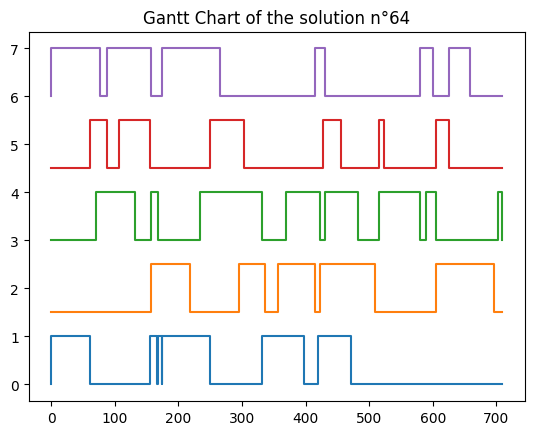

Makespan of the solution n°64 : 709
Regularity of the solution n°64 : 3248
Objective function of the solution n°64 : 2302832


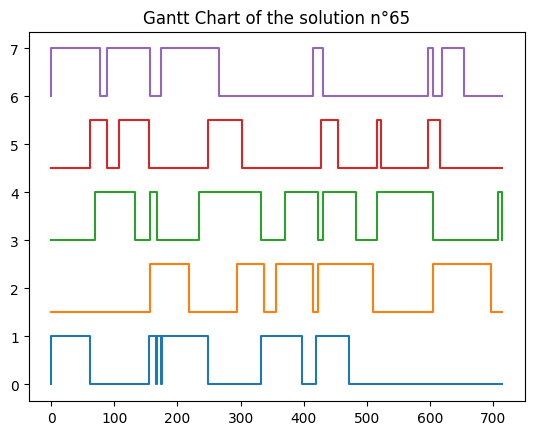

Makespan of the solution n°65 : 714
Regularity of the solution n°65 : 3244
Objective function of the solution n°65 : 2316216


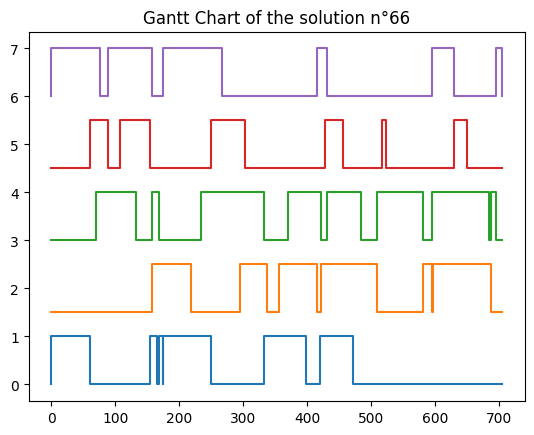

Makespan of the solution n°66 : 704
Regularity of the solution n°66 : 3254
Objective function of the solution n°66 : 2290816


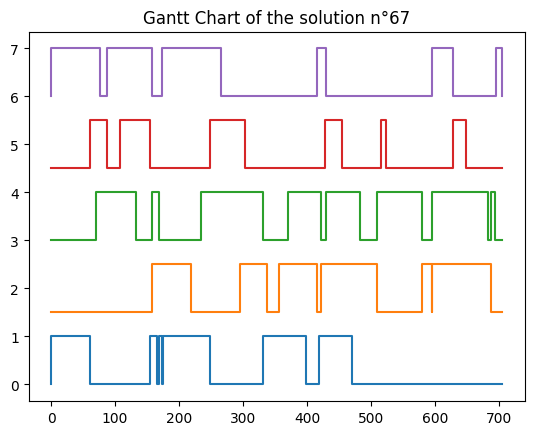

Makespan of the solution n°67 : 705
Regularity of the solution n°67 : 3256
Objective function of the solution n°67 : 2295480


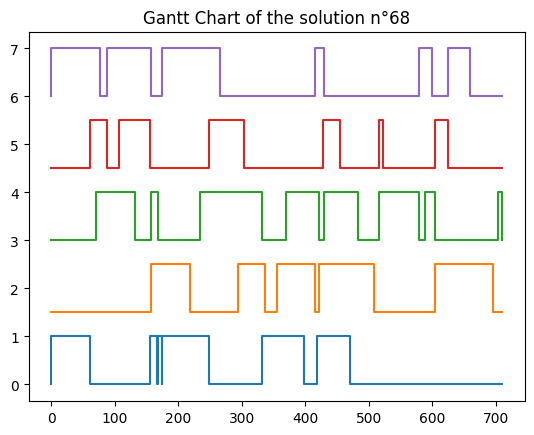

Makespan of the solution n°68 : 710
Regularity of the solution n°68 : 3252
Objective function of the solution n°68 : 2308920


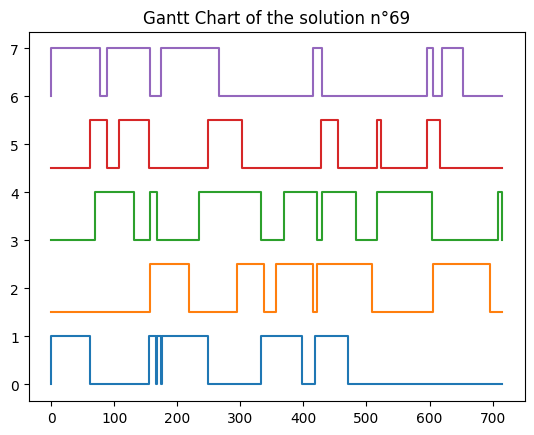

Makespan of the solution n°69 : 715
Regularity of the solution n°69 : 3248
Objective function of the solution n°69 : 2322320


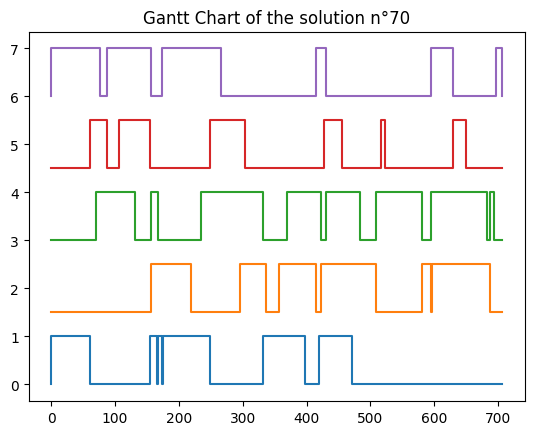

Makespan of the solution n°70 : 706
Regularity of the solution n°70 : 3258
Objective function of the solution n°70 : 2300148


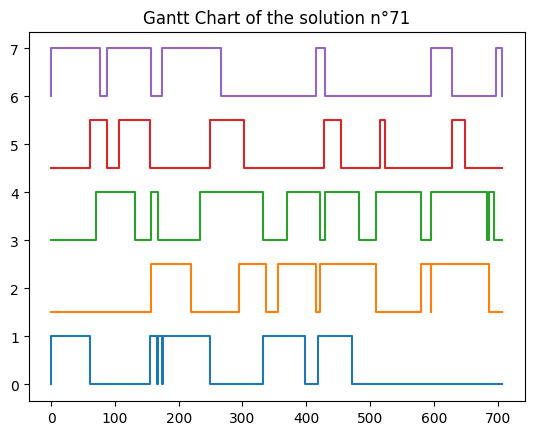

Makespan of the solution n°71 : 707
Regularity of the solution n°71 : 3260
Objective function of the solution n°71 : 2304820


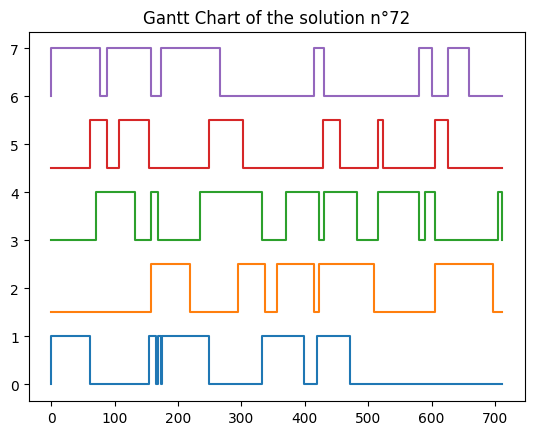

Makespan of the solution n°72 : 711
Regularity of the solution n°72 : 3256
Objective function of the solution n°72 : 2315016


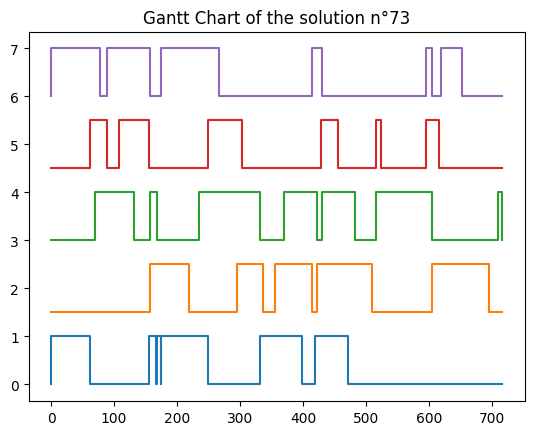

Makespan of the solution n°73 : 716
Regularity of the solution n°73 : 3252
Objective function of the solution n°73 : 2328432


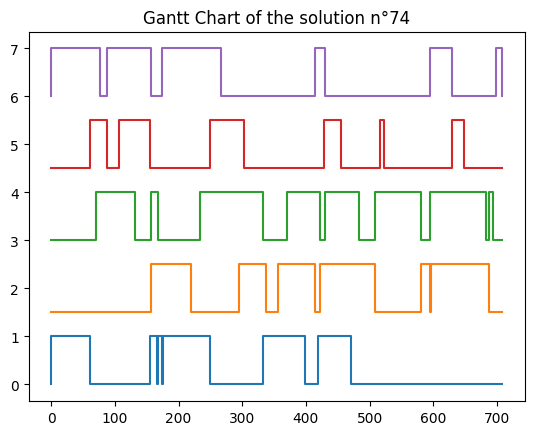

Makespan of the solution n°74 : 708
Regularity of the solution n°74 : 3262
Objective function of the solution n°74 : 2309496


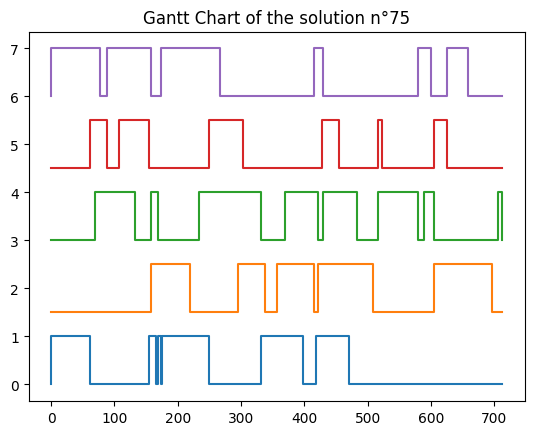

Makespan of the solution n°75 : 712
Regularity of the solution n°75 : 3260
Objective function of the solution n°75 : 2321120


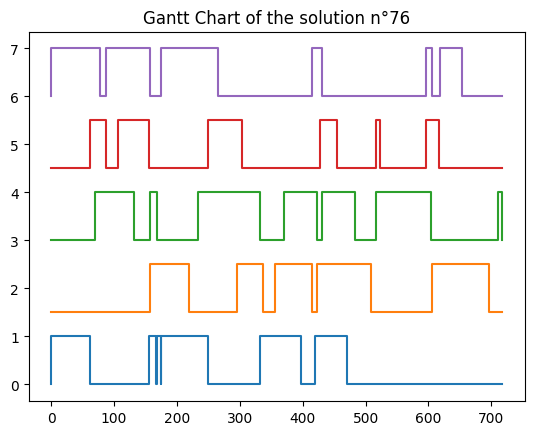

Makespan of the solution n°76 : 717
Regularity of the solution n°76 : 3256
Objective function of the solution n°76 : 2334552


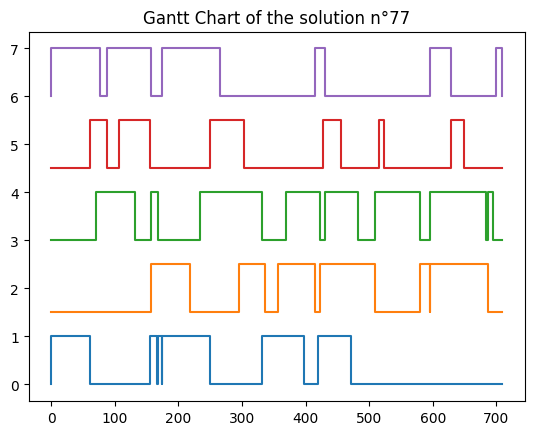

Makespan of the solution n°77 : 709
Regularity of the solution n°77 : 3264
Objective function of the solution n°77 : 2314176


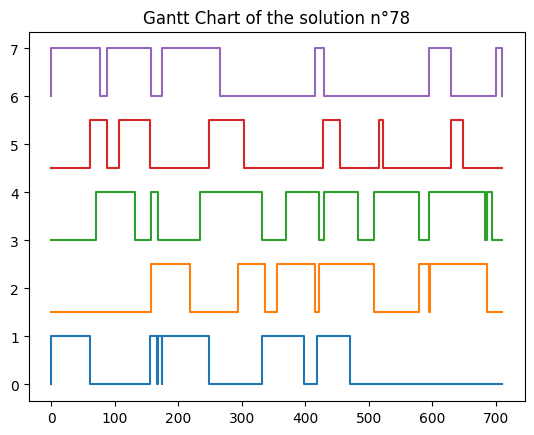

Makespan of the solution n°78 : 710
Regularity of the solution n°78 : 3266
Objective function of the solution n°78 : 2318860


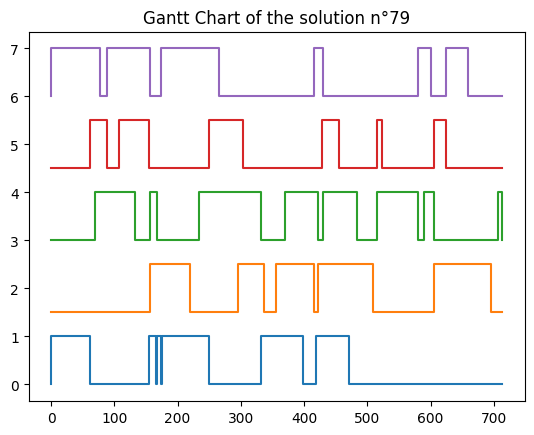

Makespan of the solution n°79 : 713
Regularity of the solution n°79 : 3264
Objective function of the solution n°79 : 2327232


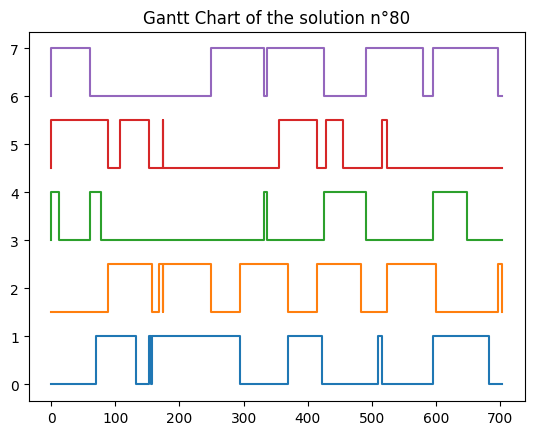

Makespan of the solution n°80 : 703
Regularity of the solution n°80 : 3274
Objective function of the solution n°80 : 2301622


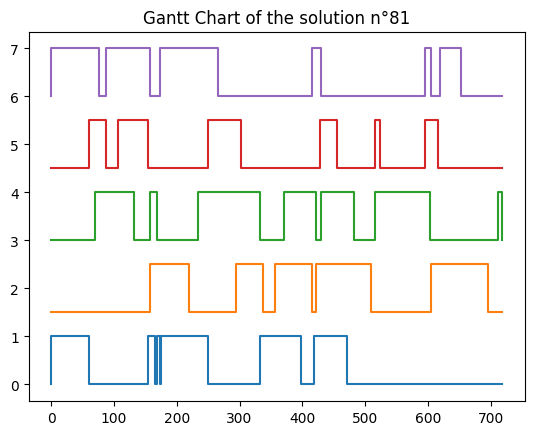

Makespan of the solution n°81 : 718
Regularity of the solution n°81 : 3260
Objective function of the solution n°81 : 2340680


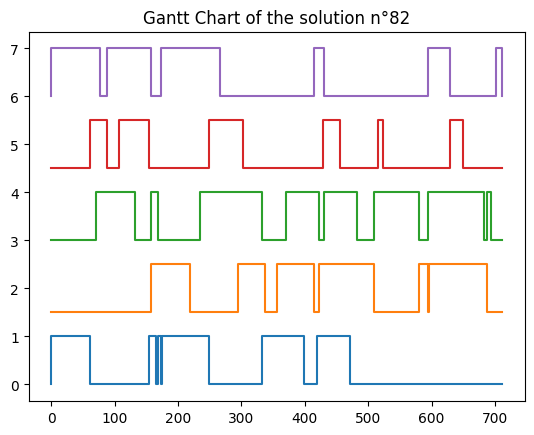

Makespan of the solution n°82 : 711
Regularity of the solution n°82 : 3268
Objective function of the solution n°82 : 2323548


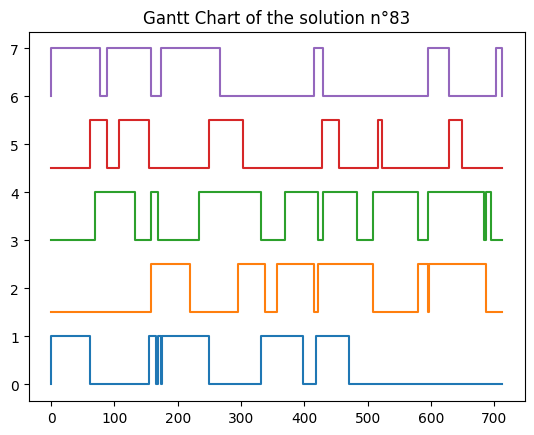

Makespan of the solution n°83 : 712
Regularity of the solution n°83 : 3270
Objective function of the solution n°83 : 2328240


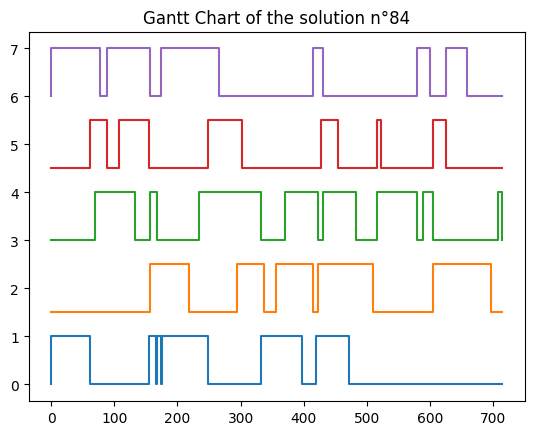

Makespan of the solution n°84 : 714
Regularity of the solution n°84 : 3268
Objective function of the solution n°84 : 2333352


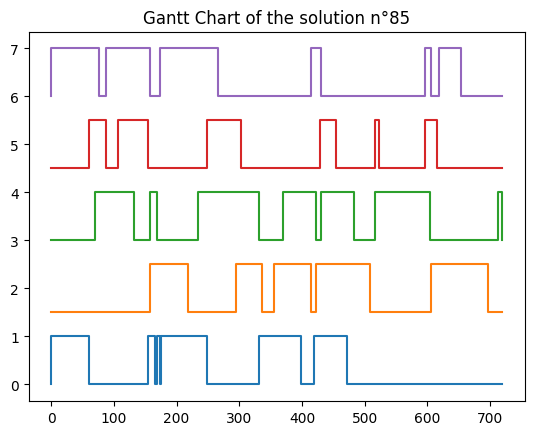

Makespan of the solution n°85 : 719
Regularity of the solution n°85 : 3264
Objective function of the solution n°85 : 2346816


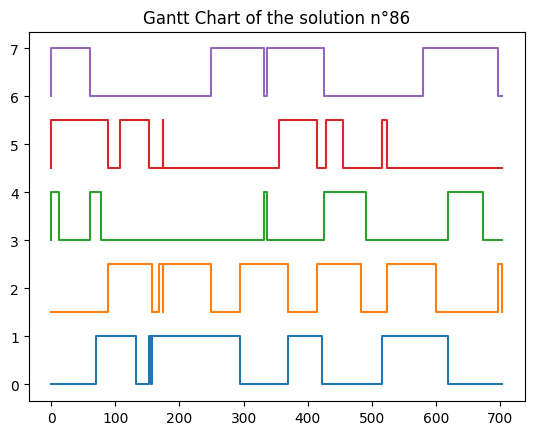

Makespan of the solution n°86 : 703
Regularity of the solution n°86 : 3280
Objective function of the solution n°86 : 2305840


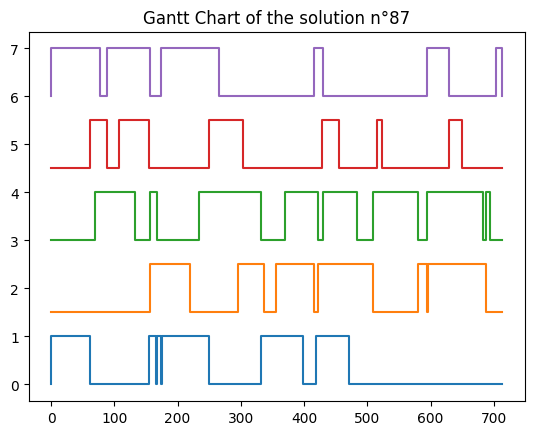

Makespan of the solution n°87 : 713
Regularity of the solution n°87 : 3272
Objective function of the solution n°87 : 2332936


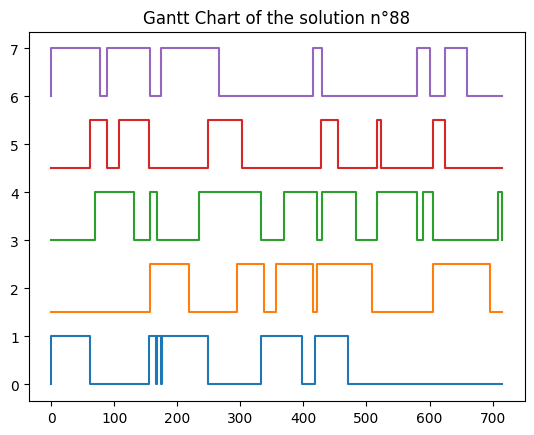

Makespan of the solution n°88 : 715
Regularity of the solution n°88 : 3272
Objective function of the solution n°88 : 2339480


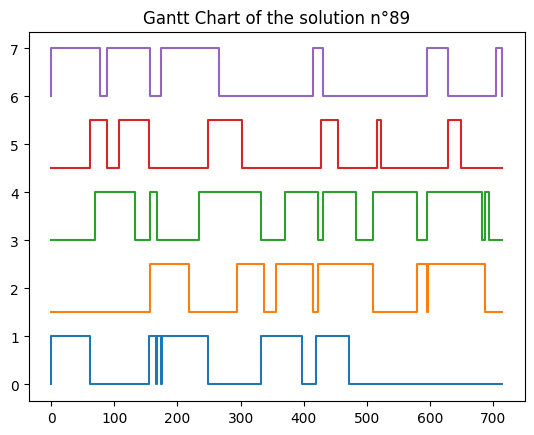

Makespan of the solution n°89 : 714
Regularity of the solution n°89 : 3274
Objective function of the solution n°89 : 2337636


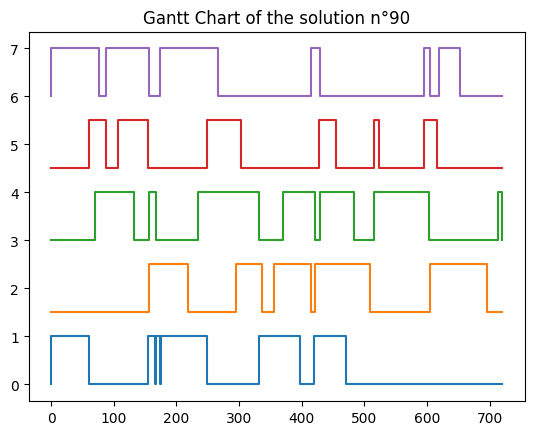

Makespan of the solution n°90 : 720
Regularity of the solution n°90 : 3268
Objective function of the solution n°90 : 2352960


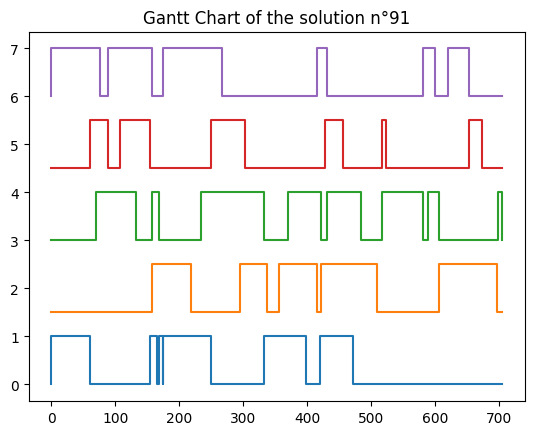

Makespan of the solution n°91 : 704
Regularity of the solution n°91 : 3284
Objective function of the solution n°91 : 2311936


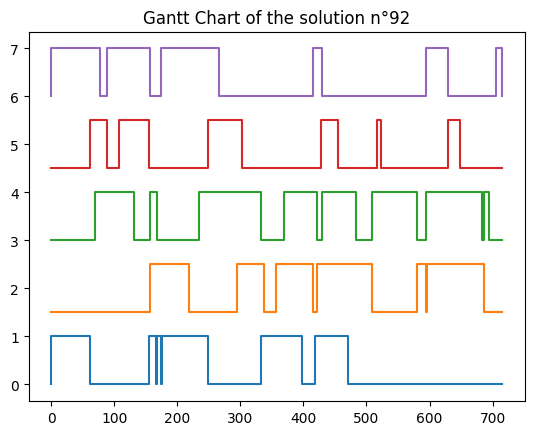

Makespan of the solution n°92 : 715
Regularity of the solution n°92 : 3276
Objective function of the solution n°92 : 2342340


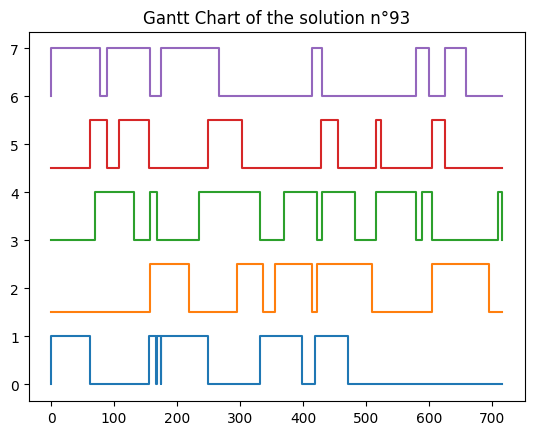

Makespan of the solution n°93 : 716
Regularity of the solution n°93 : 3276
Objective function of the solution n°93 : 2345616


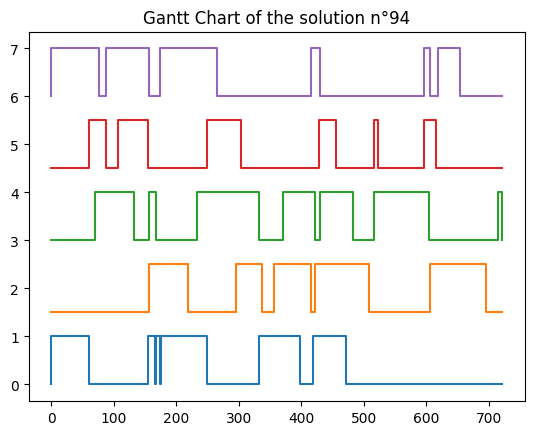

Makespan of the solution n°94 : 721
Regularity of the solution n°94 : 3272
Objective function of the solution n°94 : 2359112


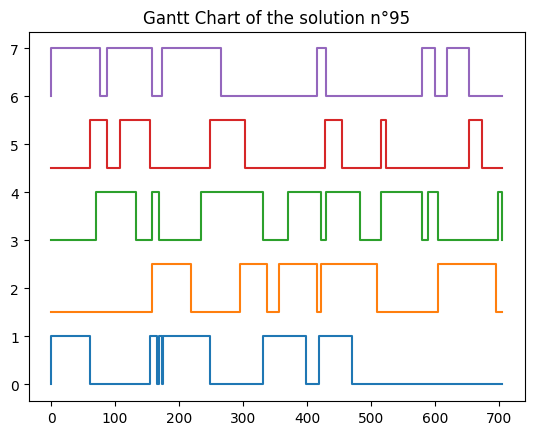

Makespan of the solution n°95 : 705
Regularity of the solution n°95 : 3288
Objective function of the solution n°95 : 2318040


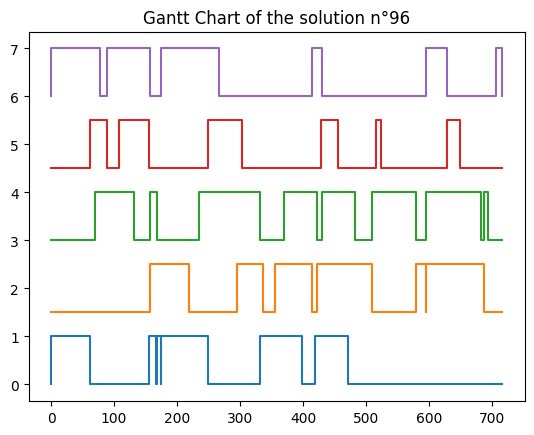

Makespan of the solution n°96 : 716
Regularity of the solution n°96 : 3278
Objective function of the solution n°96 : 2347048


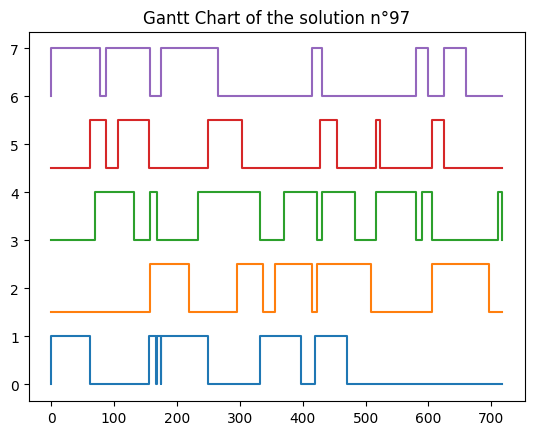

Makespan of the solution n°97 : 717
Regularity of the solution n°97 : 3280
Objective function of the solution n°97 : 2351760


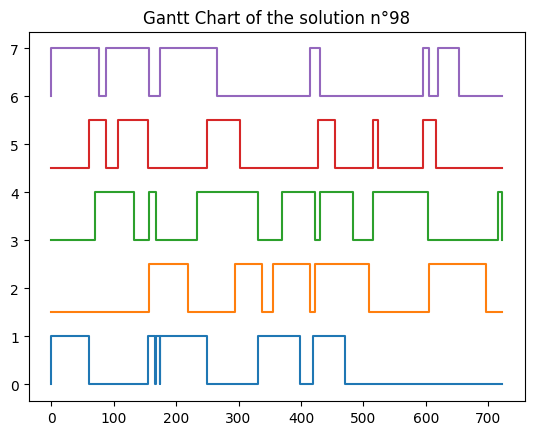

Makespan of the solution n°98 : 722
Regularity of the solution n°98 : 3276
Objective function of the solution n°98 : 2365272


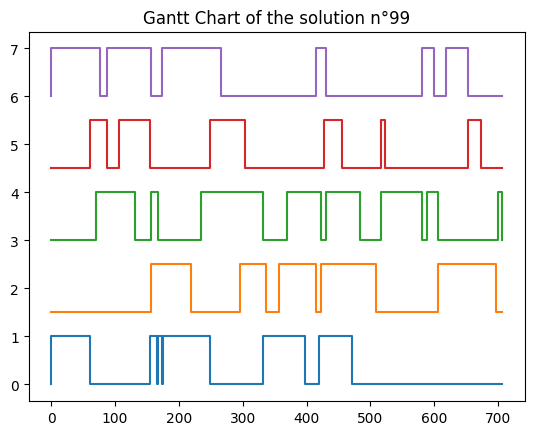

Makespan of the solution n°99 : 706
Regularity of the solution n°99 : 3292
Objective function of the solution n°99 : 2324152


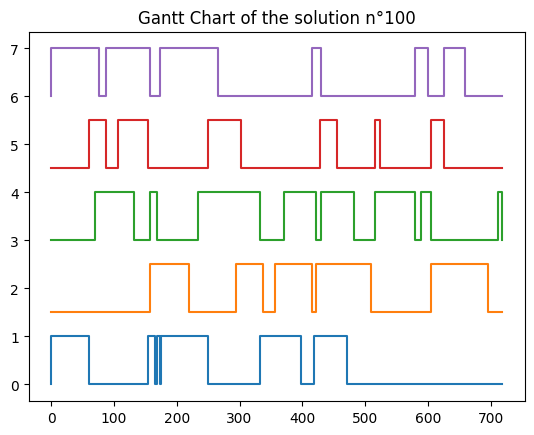

Makespan of the solution n°100 : 718
Regularity of the solution n°100 : 3284
Objective function of the solution n°100 : 2357912


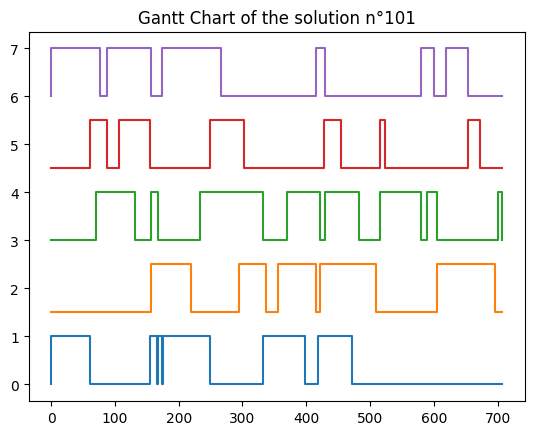

Makespan of the solution n°101 : 707
Regularity of the solution n°101 : 3296
Objective function of the solution n°101 : 2330272


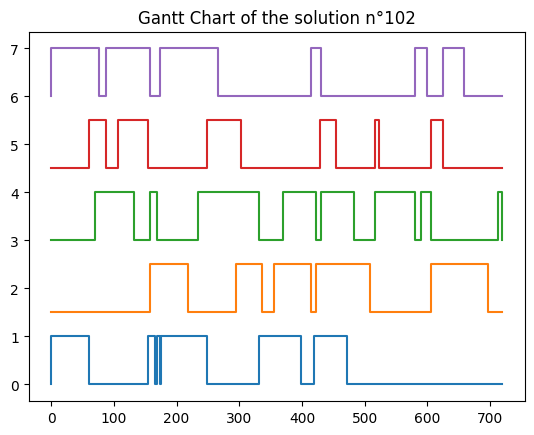

Makespan of the solution n°102 : 719
Regularity of the solution n°102 : 3288
Objective function of the solution n°102 : 2364072


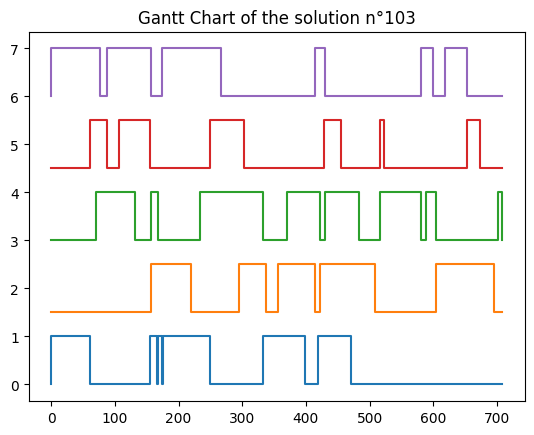

Makespan of the solution n°103 : 708
Regularity of the solution n°103 : 3300
Objective function of the solution n°103 : 2336400


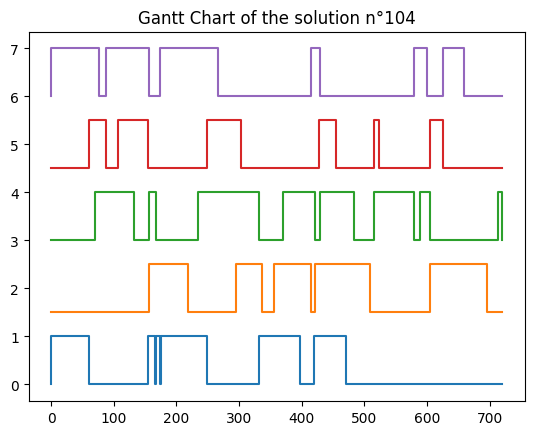

Makespan of the solution n°104 : 720
Regularity of the solution n°104 : 3292
Objective function of the solution n°104 : 2370240


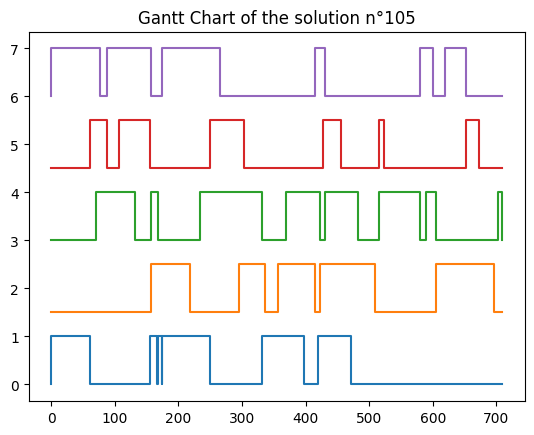

Makespan of the solution n°105 : 709
Regularity of the solution n°105 : 3304
Objective function of the solution n°105 : 2342536


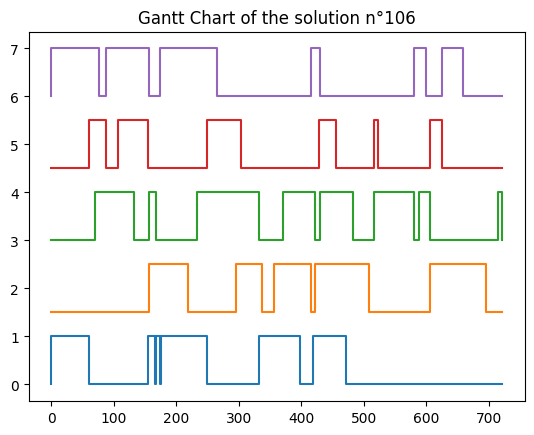

Makespan of the solution n°106 : 721
Regularity of the solution n°106 : 3296
Objective function of the solution n°106 : 2376416


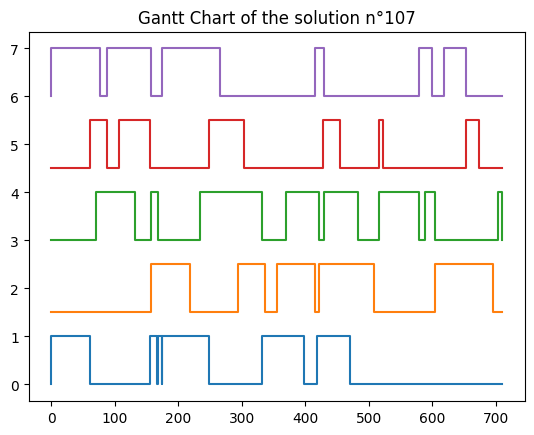

Makespan of the solution n°107 : 710
Regularity of the solution n°107 : 3308
Objective function of the solution n°107 : 2348680


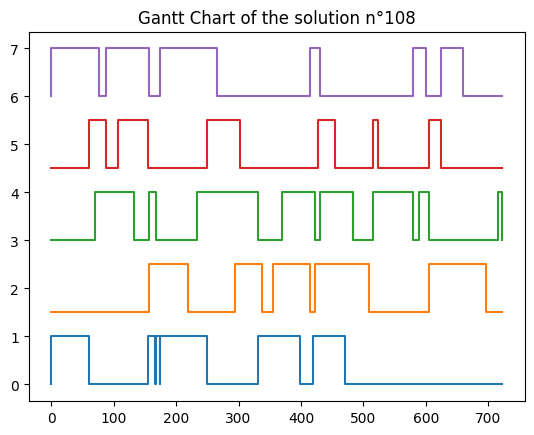

Makespan of the solution n°108 : 722
Regularity of the solution n°108 : 3300
Objective function of the solution n°108 : 2382600


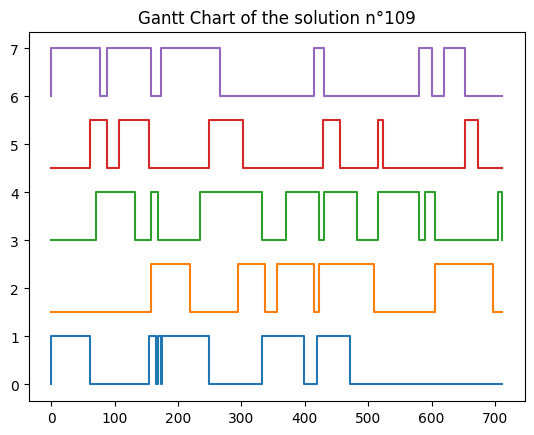

Makespan of the solution n°109 : 711
Regularity of the solution n°109 : 3312
Objective function of the solution n°109 : 2354832


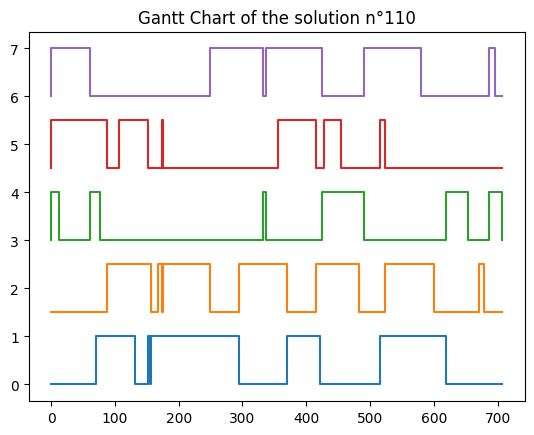

Makespan of the solution n°110 : 707
Regularity of the solution n°110 : 3316
Objective function of the solution n°110 : 2344412


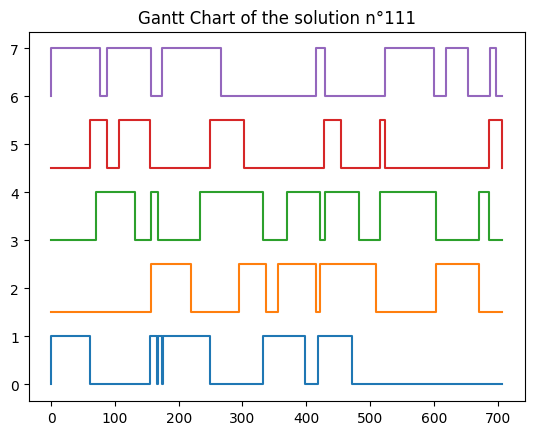

Makespan of the solution n°111 : 707
Regularity of the solution n°111 : 3318
Objective function of the solution n°111 : 2345826


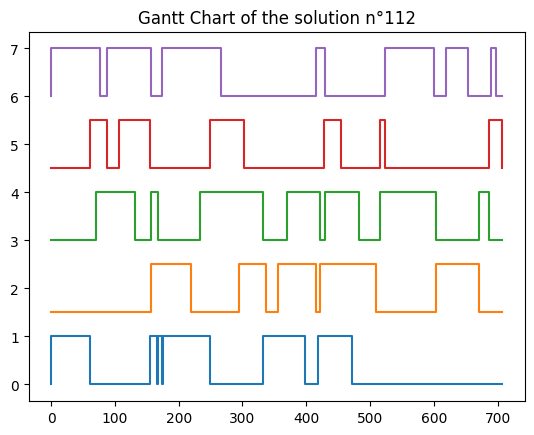

Makespan of the solution n°112 : 707
Regularity of the solution n°112 : 3320
Objective function of the solution n°112 : 2347240


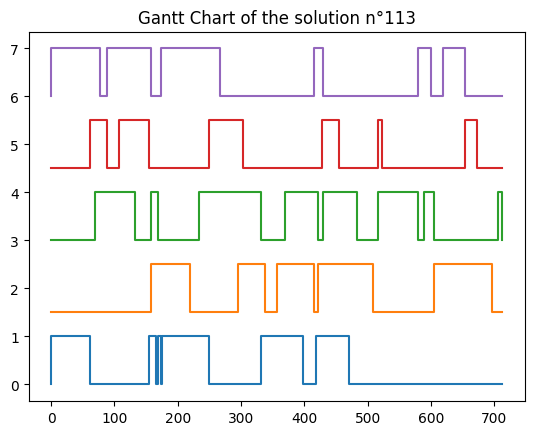

Makespan of the solution n°113 : 712
Regularity of the solution n°113 : 3316
Objective function of the solution n°113 : 2360992


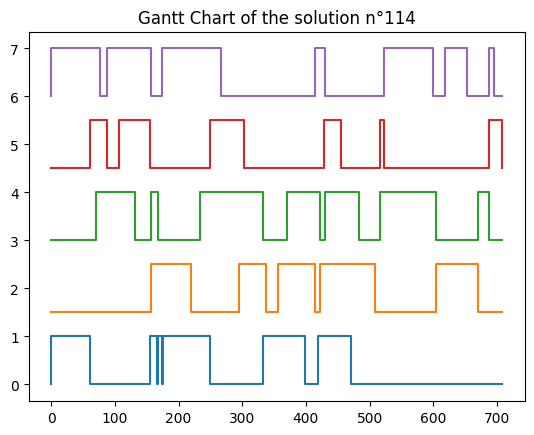

Makespan of the solution n°114 : 708
Regularity of the solution n°114 : 3320
Objective function of the solution n°114 : 2350560


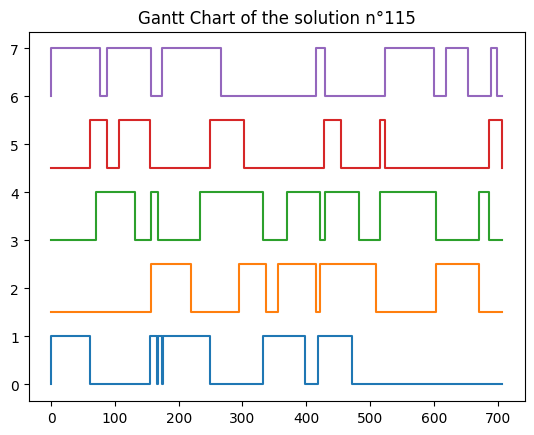

Makespan of the solution n°115 : 707
Regularity of the solution n°115 : 3322
Objective function of the solution n°115 : 2348654


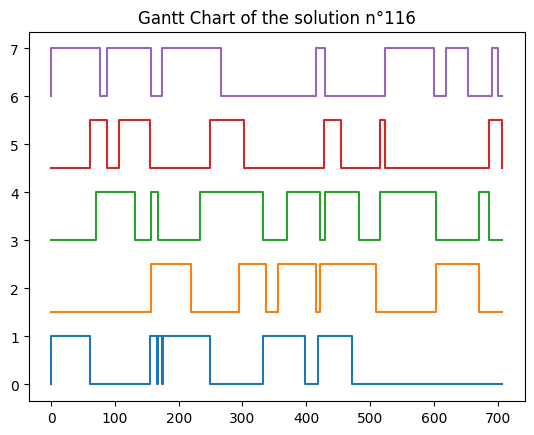

Makespan of the solution n°116 : 707
Regularity of the solution n°116 : 3324
Objective function of the solution n°116 : 2350068


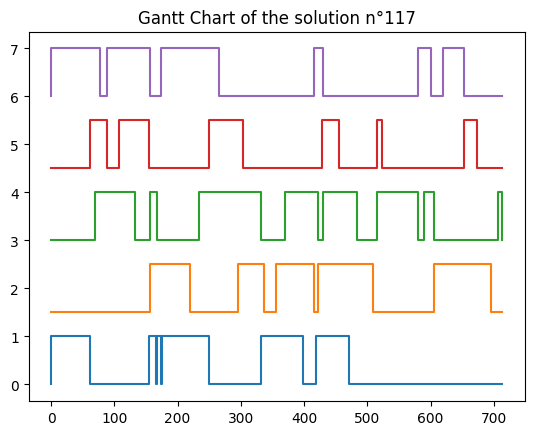

Makespan of the solution n°117 : 713
Regularity of the solution n°117 : 3320
Objective function of the solution n°117 : 2367160


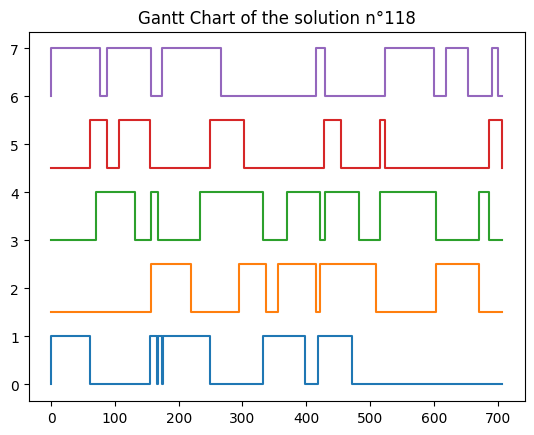

Makespan of the solution n°118 : 707
Regularity of the solution n°118 : 3326
Objective function of the solution n°118 : 2351482


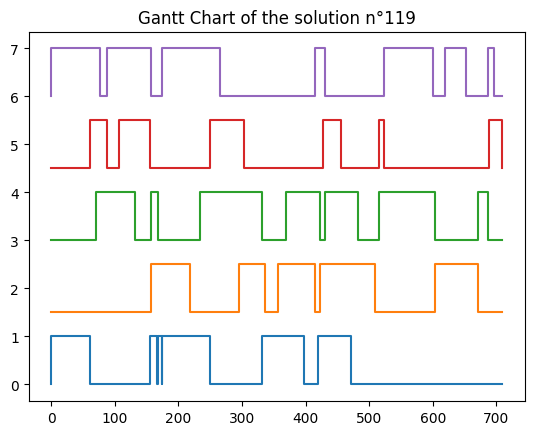

Makespan of the solution n°119 : 709
Regularity of the solution n°119 : 3324
Objective function of the solution n°119 : 2356716


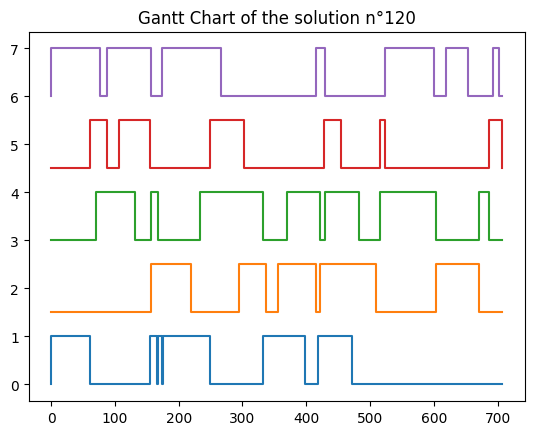

Makespan of the solution n°120 : 707
Regularity of the solution n°120 : 3328
Objective function of the solution n°120 : 2352896


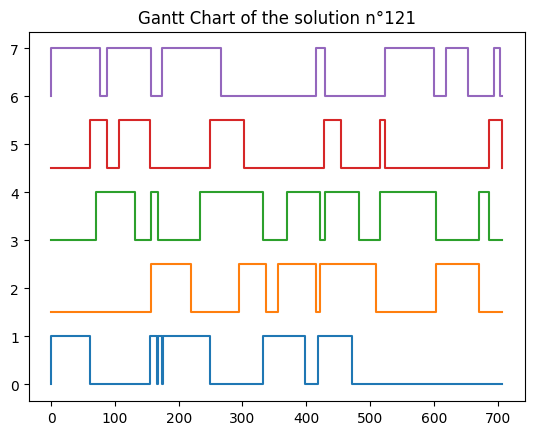

Makespan of the solution n°121 : 707
Regularity of the solution n°121 : 3330
Objective function of the solution n°121 : 2354310


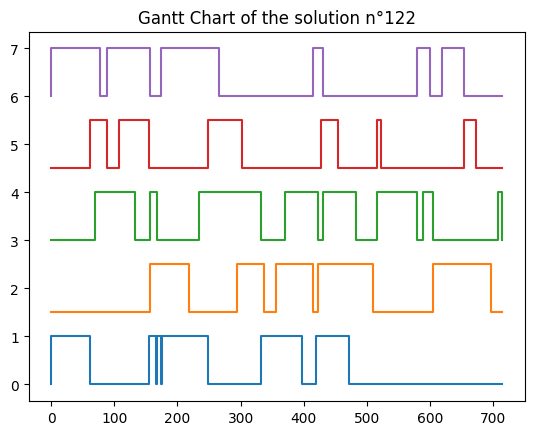

Makespan of the solution n°122 : 714
Regularity of the solution n°122 : 3324
Objective function of the solution n°122 : 2373336


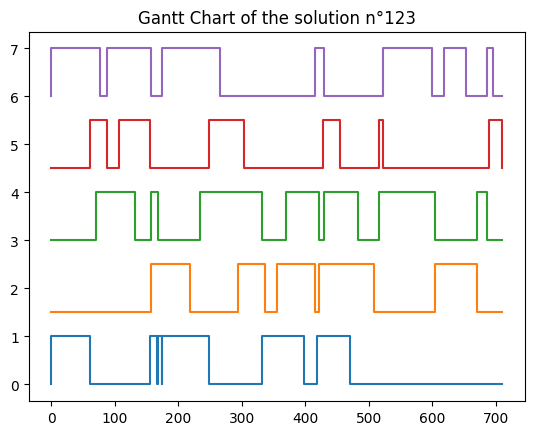

Makespan of the solution n°123 : 710
Regularity of the solution n°123 : 3328
Objective function of the solution n°123 : 2362880


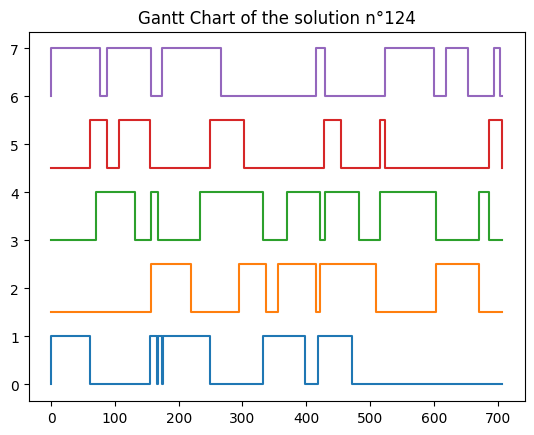

Makespan of the solution n°124 : 707
Regularity of the solution n°124 : 3332
Objective function of the solution n°124 : 2355724


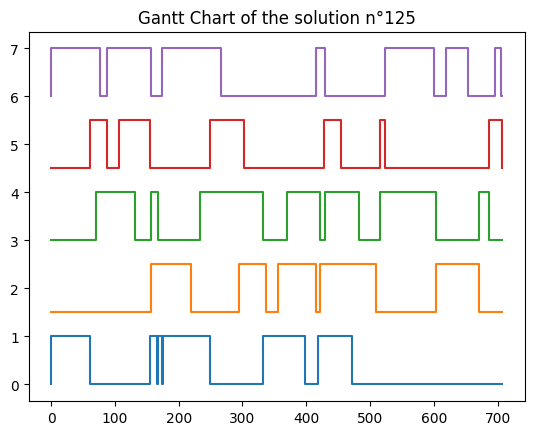

Makespan of the solution n°125 : 707
Regularity of the solution n°125 : 3334
Objective function of the solution n°125 : 2357138


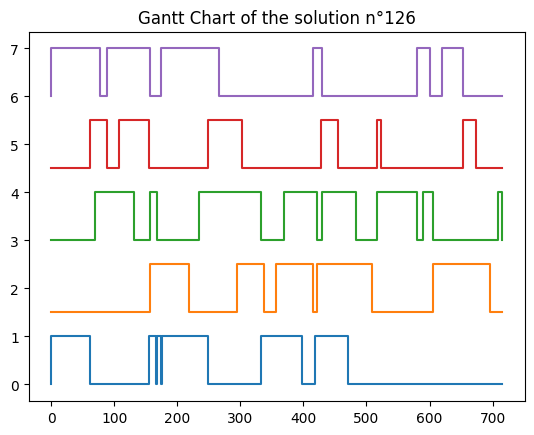

Makespan of the solution n°126 : 715
Regularity of the solution n°126 : 3328
Objective function of the solution n°126 : 2379520


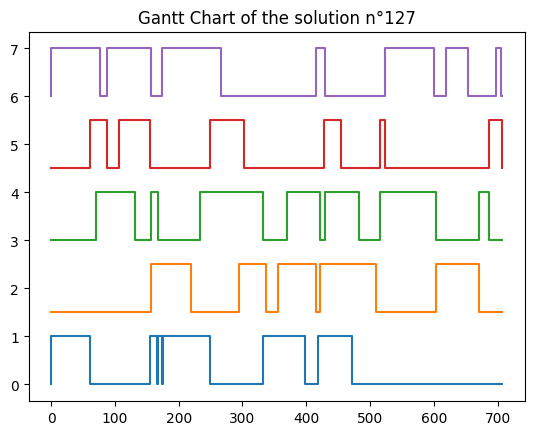

Makespan of the solution n°127 : 707
Regularity of the solution n°127 : 3336
Objective function of the solution n°127 : 2358552


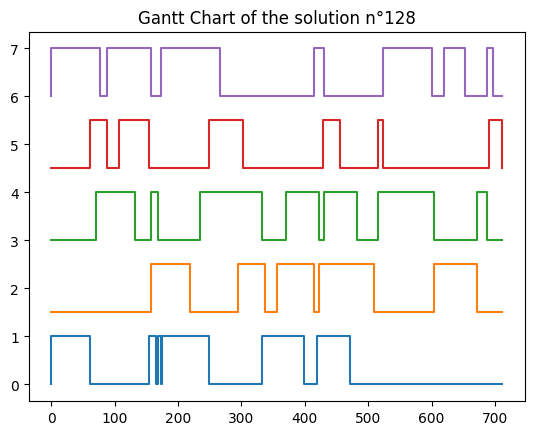

Makespan of the solution n°128 : 711
Regularity of the solution n°128 : 3332
Objective function of the solution n°128 : 2369052


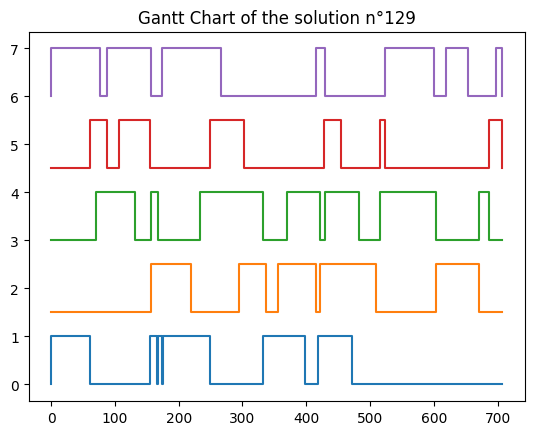

Makespan of the solution n°129 : 707
Regularity of the solution n°129 : 3338
Objective function of the solution n°129 : 2359966


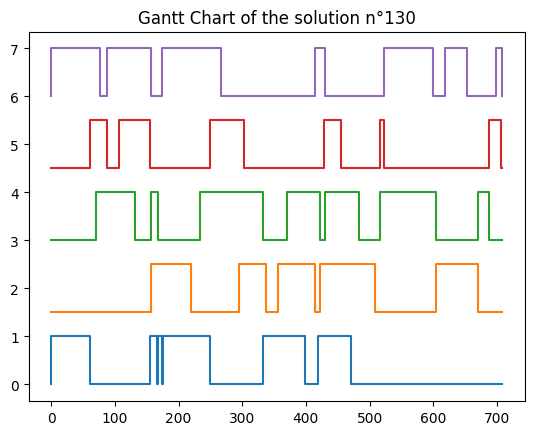

Makespan of the solution n°130 : 708
Regularity of the solution n°130 : 3340
Objective function of the solution n°130 : 2364720


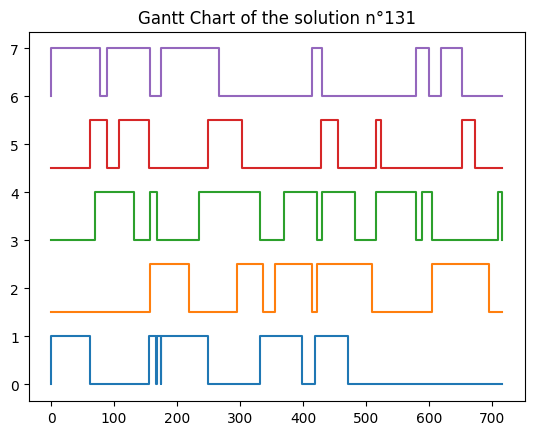

Makespan of the solution n°131 : 716
Regularity of the solution n°131 : 3332
Objective function of the solution n°131 : 2385712


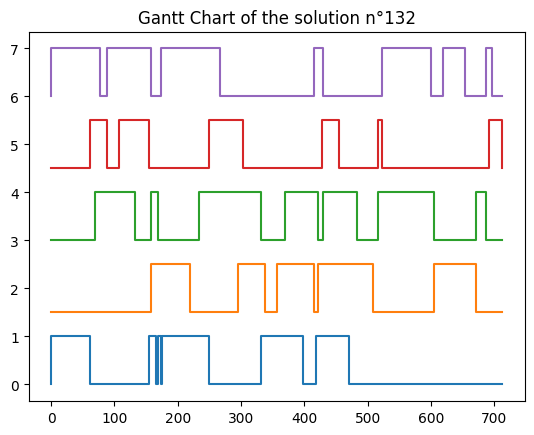

Makespan of the solution n°132 : 712
Regularity of the solution n°132 : 3336
Objective function of the solution n°132 : 2375232


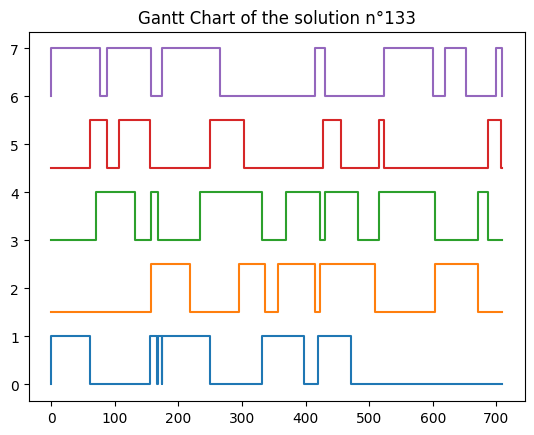

Makespan of the solution n°133 : 709
Regularity of the solution n°133 : 3342
Objective function of the solution n°133 : 2369478


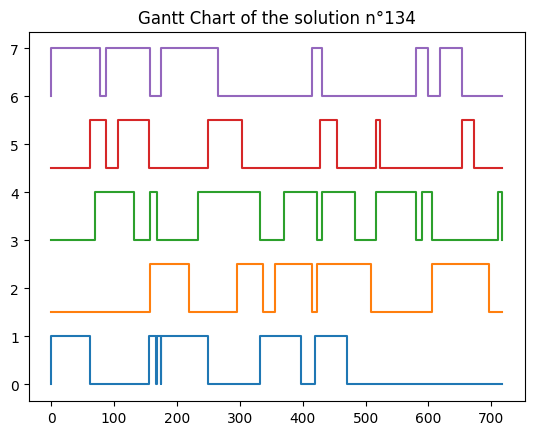

Makespan of the solution n°134 : 717
Regularity of the solution n°134 : 3336
Objective function of the solution n°134 : 2391912


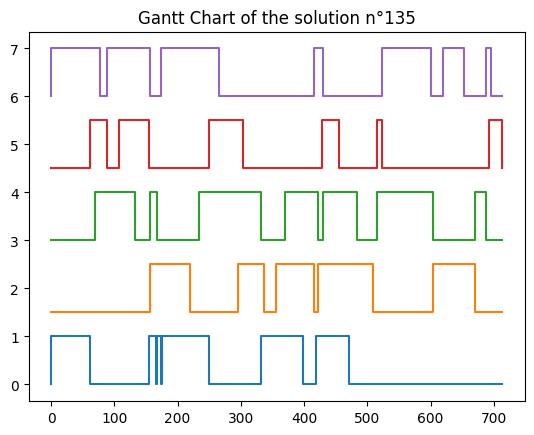

Makespan of the solution n°135 : 713
Regularity of the solution n°135 : 3340
Objective function of the solution n°135 : 2381420


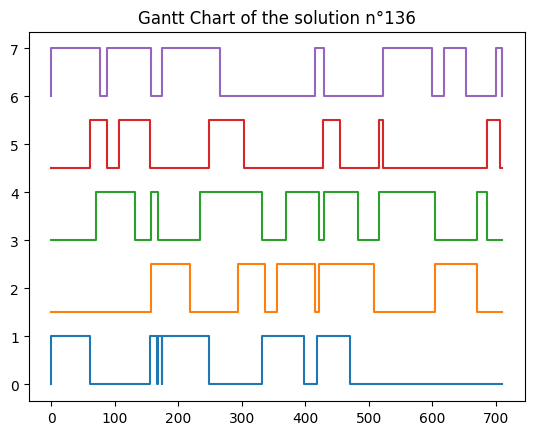

Makespan of the solution n°136 : 710
Regularity of the solution n°136 : 3344
Objective function of the solution n°136 : 2374240


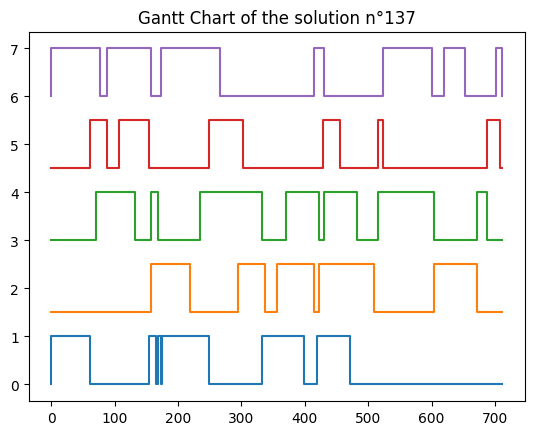

Makespan of the solution n°137 : 711
Regularity of the solution n°137 : 3346
Objective function of the solution n°137 : 2379006


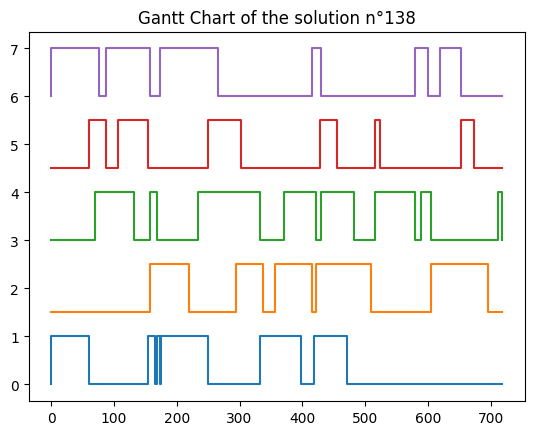

Makespan of the solution n°138 : 718
Regularity of the solution n°138 : 3340
Objective function of the solution n°138 : 2398120


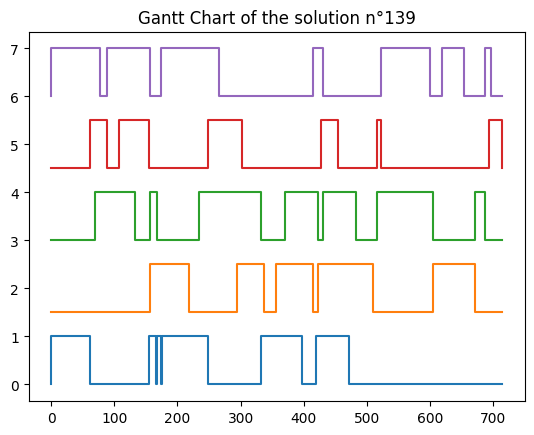

Makespan of the solution n°139 : 714
Regularity of the solution n°139 : 3344
Objective function of the solution n°139 : 2387616


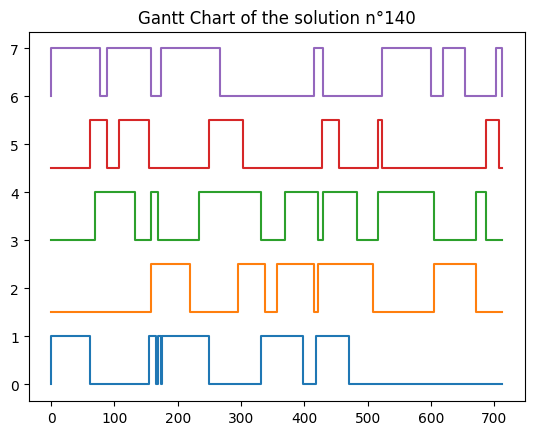

Makespan of the solution n°140 : 712
Regularity of the solution n°140 : 3348
Objective function of the solution n°140 : 2383776


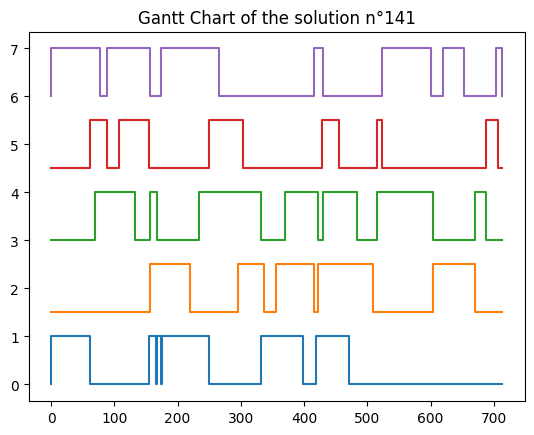

Makespan of the solution n°141 : 713
Regularity of the solution n°141 : 3350
Objective function of the solution n°141 : 2388550


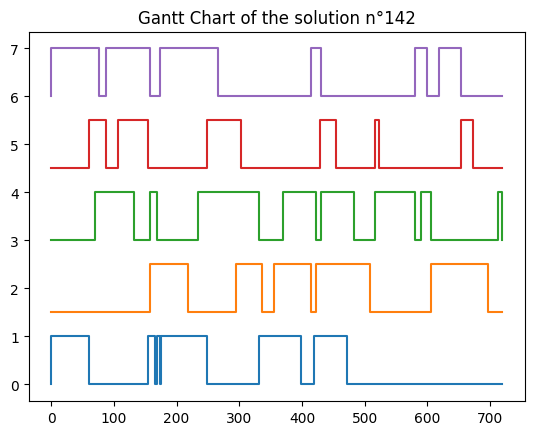

Makespan of the solution n°142 : 719
Regularity of the solution n°142 : 3344
Objective function of the solution n°142 : 2404336


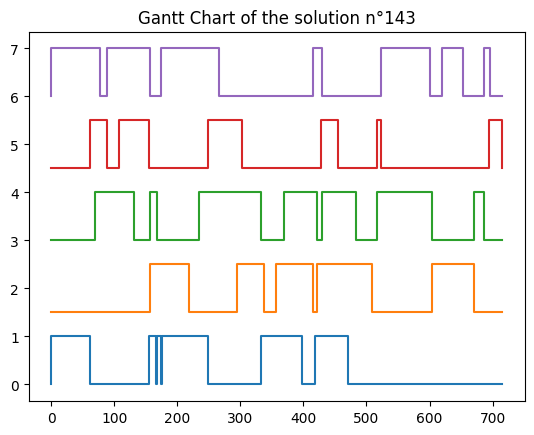

Makespan of the solution n°143 : 715
Regularity of the solution n°143 : 3348
Objective function of the solution n°143 : 2393820


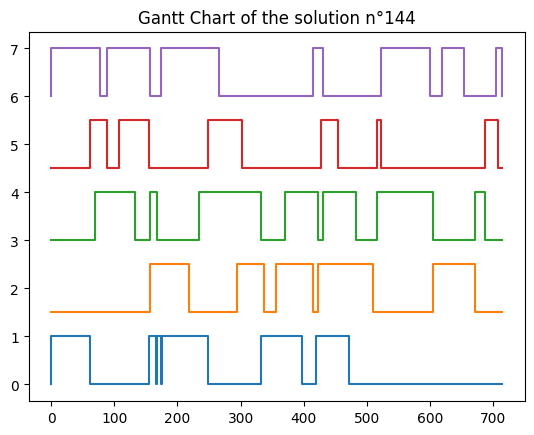

Makespan of the solution n°144 : 714
Regularity of the solution n°144 : 3352
Objective function of the solution n°144 : 2393328


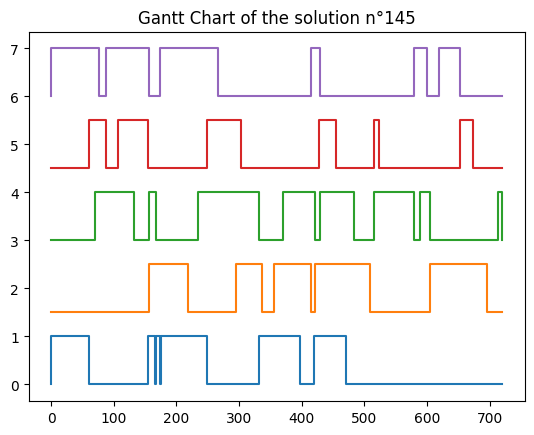

Makespan of the solution n°145 : 720
Regularity of the solution n°145 : 3348
Objective function of the solution n°145 : 2410560


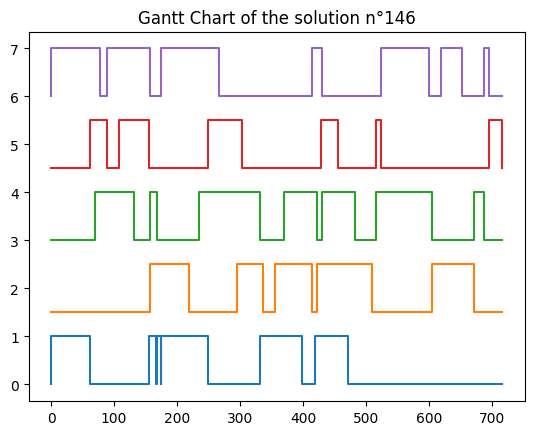

Makespan of the solution n°146 : 716
Regularity of the solution n°146 : 3352
Objective function of the solution n°146 : 2400032


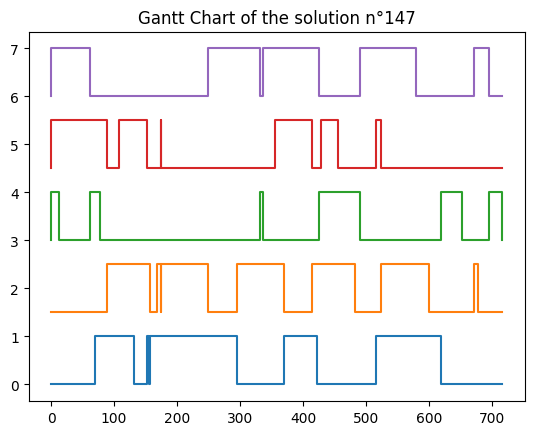

Makespan of the solution n°147 : 716
Regularity of the solution n°147 : 3352
Objective function of the solution n°147 : 2400032


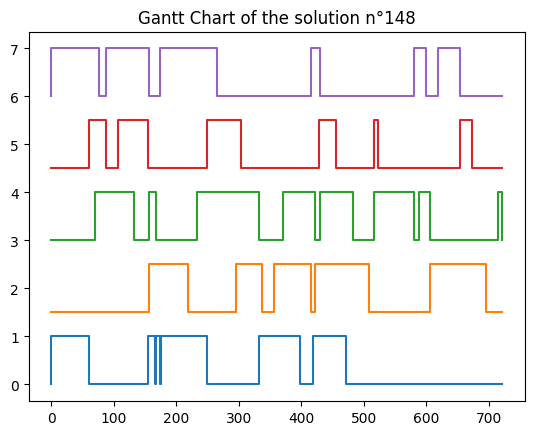

Makespan of the solution n°148 : 721
Regularity of the solution n°148 : 3352
Objective function of the solution n°148 : 2416792


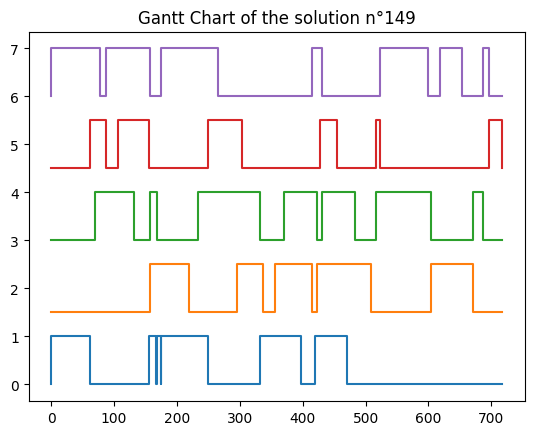

Makespan of the solution n°149 : 717
Regularity of the solution n°149 : 3356
Objective function of the solution n°149 : 2406252


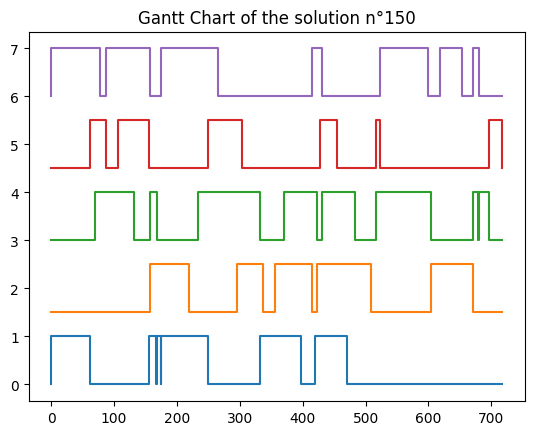

Makespan of the solution n°150 : 717
Regularity of the solution n°150 : 3356
Objective function of the solution n°150 : 2406252


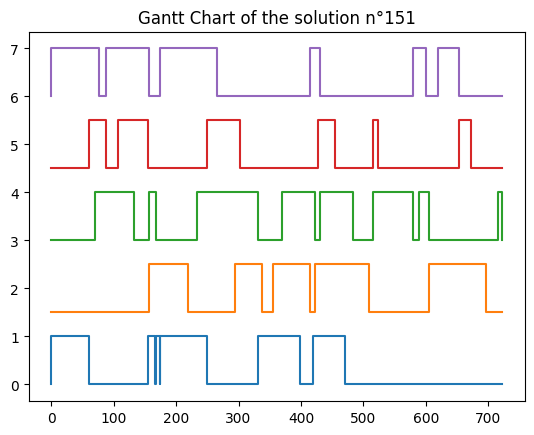

Makespan of the solution n°151 : 722
Regularity of the solution n°151 : 3356
Objective function of the solution n°151 : 2423032


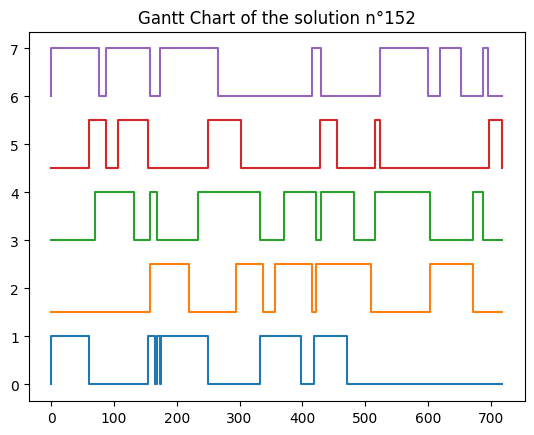

Makespan of the solution n°152 : 718
Regularity of the solution n°152 : 3360
Objective function of the solution n°152 : 2412480


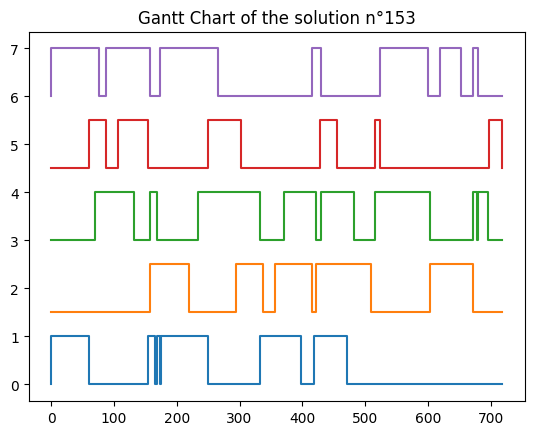

Makespan of the solution n°153 : 718
Regularity of the solution n°153 : 3360
Objective function of the solution n°153 : 2412480


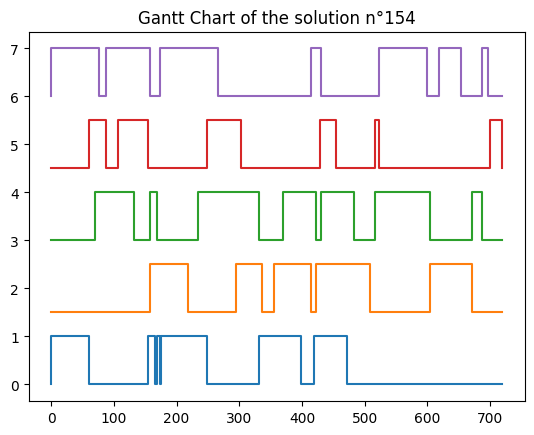

Makespan of the solution n°154 : 719
Regularity of the solution n°154 : 3364
Objective function of the solution n°154 : 2418716


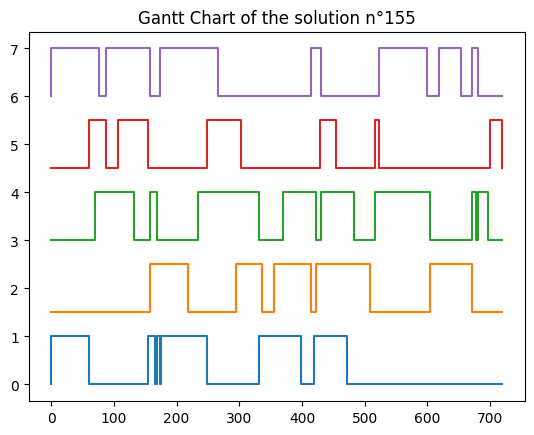

Makespan of the solution n°155 : 719
Regularity of the solution n°155 : 3364
Objective function of the solution n°155 : 2418716


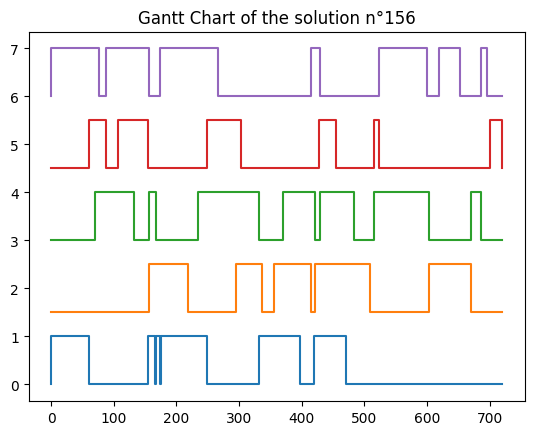

Makespan of the solution n°156 : 720
Regularity of the solution n°156 : 3368
Objective function of the solution n°156 : 2424960


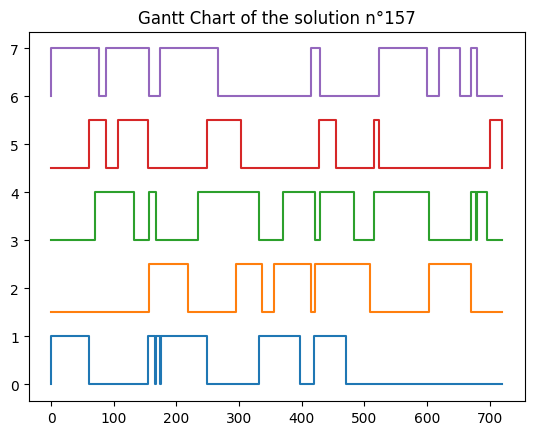

Makespan of the solution n°157 : 720
Regularity of the solution n°157 : 3368
Objective function of the solution n°157 : 2424960


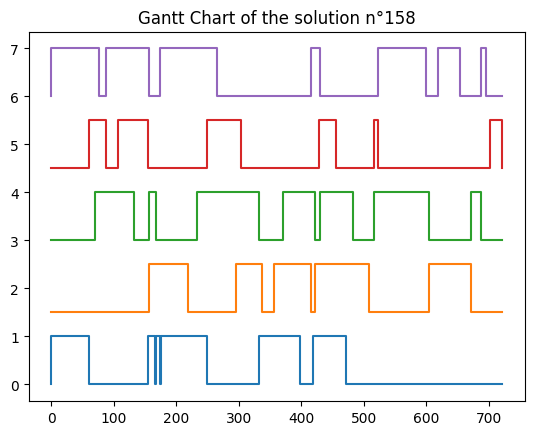

Makespan of the solution n°158 : 721
Regularity of the solution n°158 : 3372
Objective function of the solution n°158 : 2431212


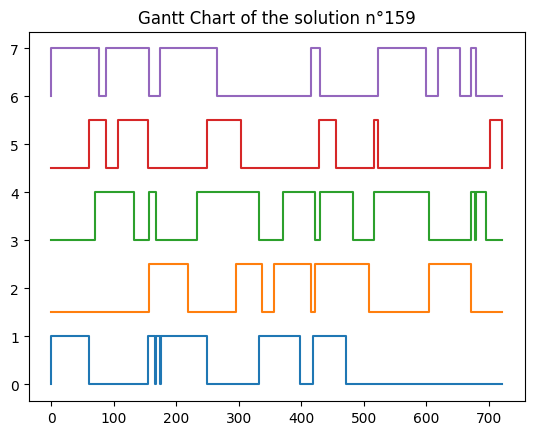

Makespan of the solution n°159 : 721
Regularity of the solution n°159 : 3372
Objective function of the solution n°159 : 2431212


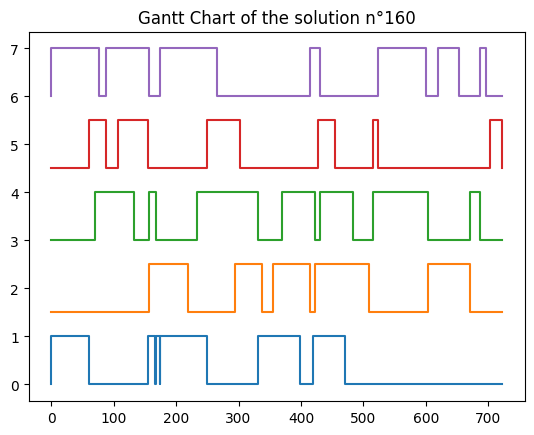

Makespan of the solution n°160 : 722
Regularity of the solution n°160 : 3376
Objective function of the solution n°160 : 2437472


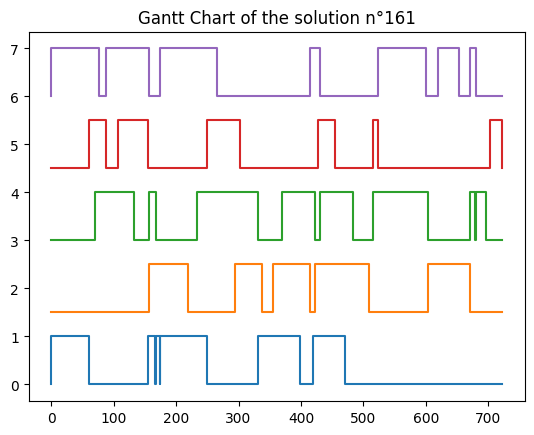

Makespan of the solution n°161 : 722
Regularity of the solution n°161 : 3376
Objective function of the solution n°161 : 2437472


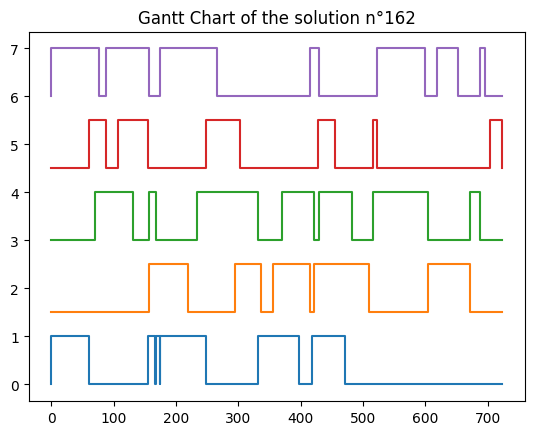

Makespan of the solution n°162 : 723
Regularity of the solution n°162 : 3380
Objective function of the solution n°162 : 2443740


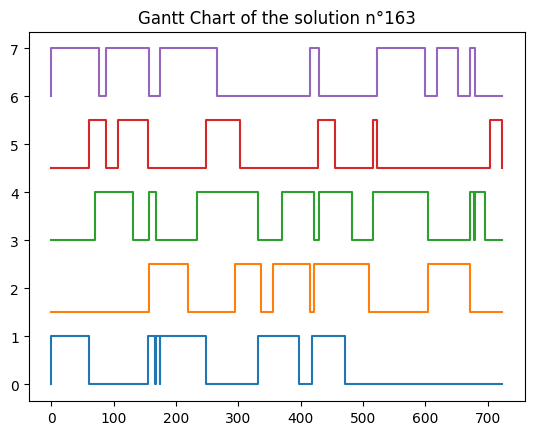

Makespan of the solution n°163 : 723
Regularity of the solution n°163 : 3380
Objective function of the solution n°163 : 2443740


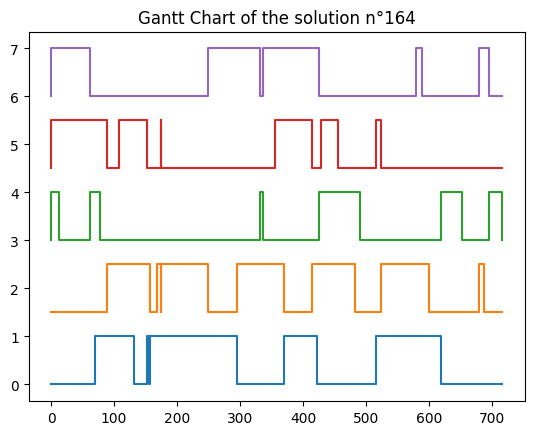

Makespan of the solution n°164 : 716
Regularity of the solution n°164 : 3388
Objective function of the solution n°164 : 2425808


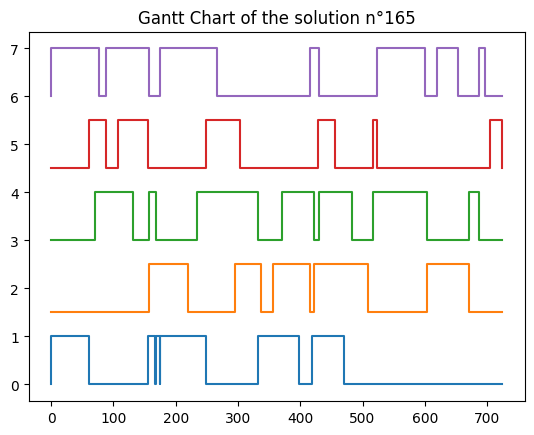

Makespan of the solution n°165 : 724
Regularity of the solution n°165 : 3384
Objective function of the solution n°165 : 2450016


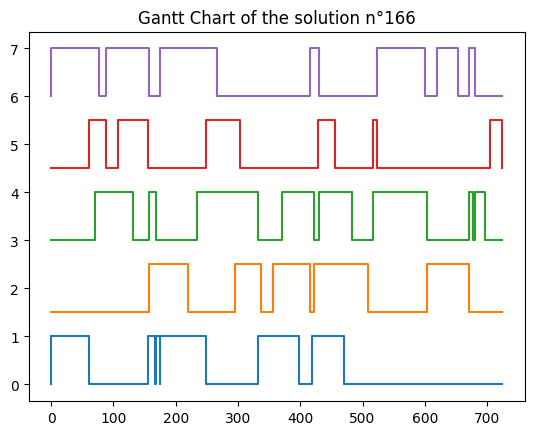

Makespan of the solution n°166 : 724
Regularity of the solution n°166 : 3384
Objective function of the solution n°166 : 2450016


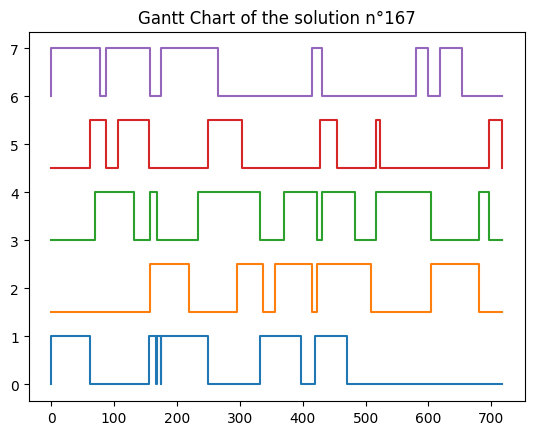

Makespan of the solution n°167 : 717
Regularity of the solution n°167 : 3392
Objective function of the solution n°167 : 2432064


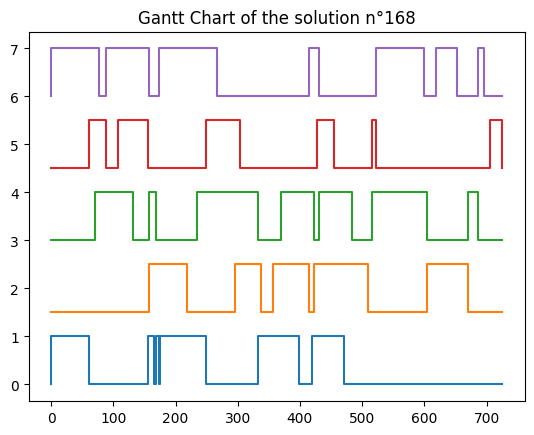

Makespan of the solution n°168 : 725
Regularity of the solution n°168 : 3388
Objective function of the solution n°168 : 2456300


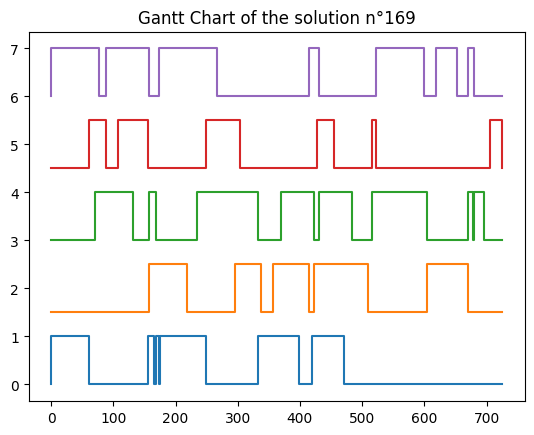

Makespan of the solution n°169 : 725
Regularity of the solution n°169 : 3388
Objective function of the solution n°169 : 2456300


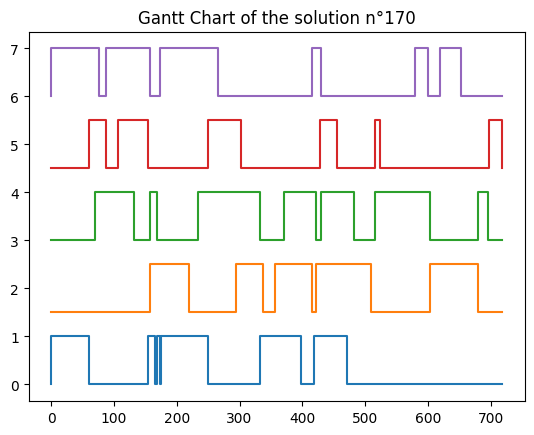

Makespan of the solution n°170 : 718
Regularity of the solution n°170 : 3396
Objective function of the solution n°170 : 2438328


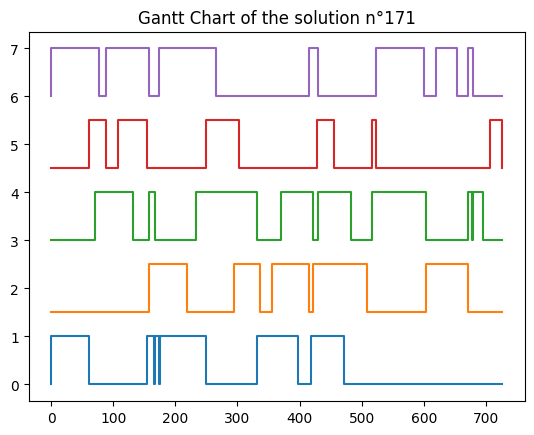

Makespan of the solution n°171 : 726
Regularity of the solution n°171 : 3392
Objective function of the solution n°171 : 2462592


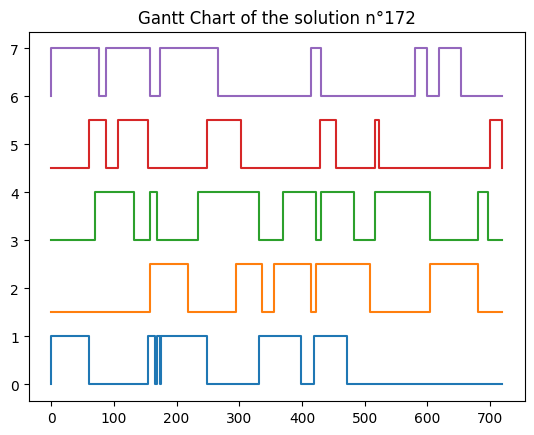

Makespan of the solution n°172 : 719
Regularity of the solution n°172 : 3400
Objective function of the solution n°172 : 2444600


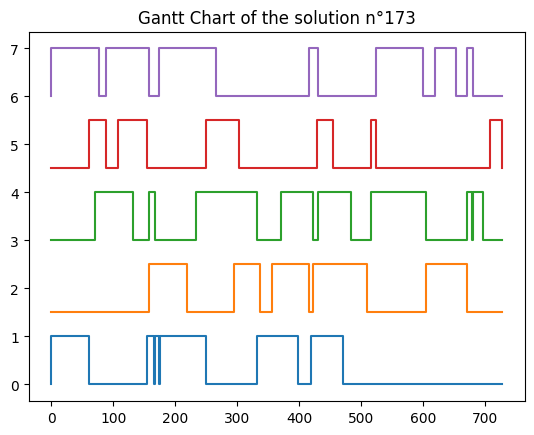

Makespan of the solution n°173 : 727
Regularity of the solution n°173 : 3396
Objective function of the solution n°173 : 2468892


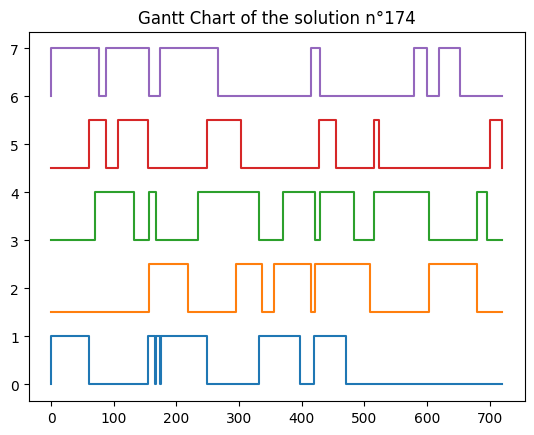

Makespan of the solution n°174 : 720
Regularity of the solution n°174 : 3404
Objective function of the solution n°174 : 2450880


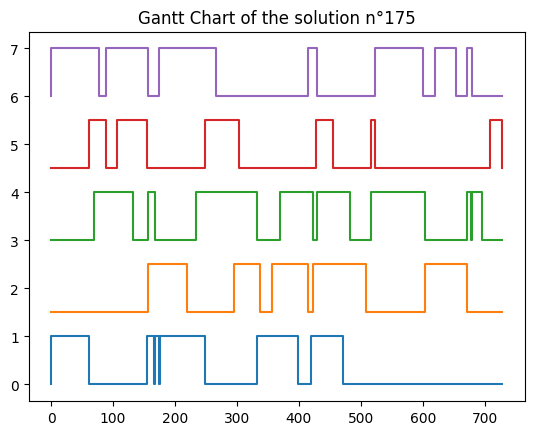

Makespan of the solution n°175 : 728
Regularity of the solution n°175 : 3400
Objective function of the solution n°175 : 2475200


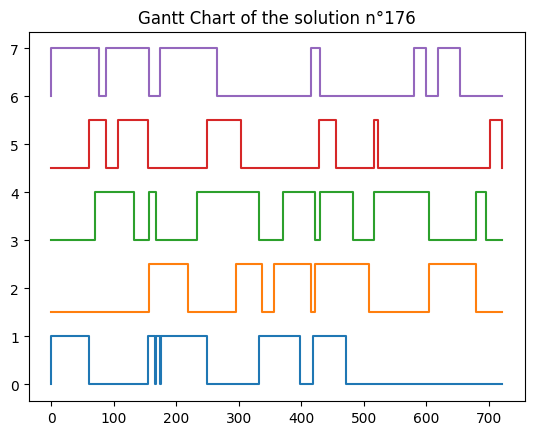

Makespan of the solution n°176 : 721
Regularity of the solution n°176 : 3408
Objective function of the solution n°176 : 2457168


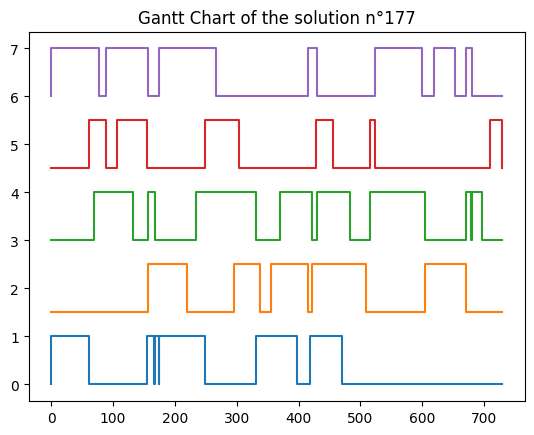

Makespan of the solution n°177 : 729
Regularity of the solution n°177 : 3404
Objective function of the solution n°177 : 2481516


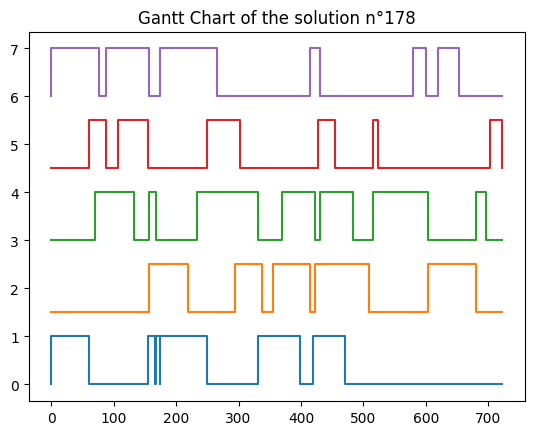

Makespan of the solution n°178 : 722
Regularity of the solution n°178 : 3412
Objective function of the solution n°178 : 2463464


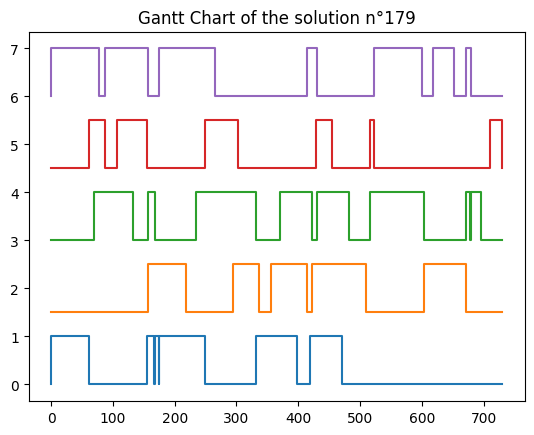

Makespan of the solution n°179 : 730
Regularity of the solution n°179 : 3408
Objective function of the solution n°179 : 2487840


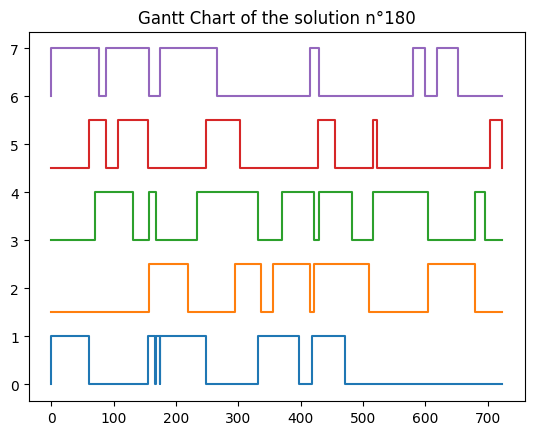

Makespan of the solution n°180 : 723
Regularity of the solution n°180 : 3416
Objective function of the solution n°180 : 2469768


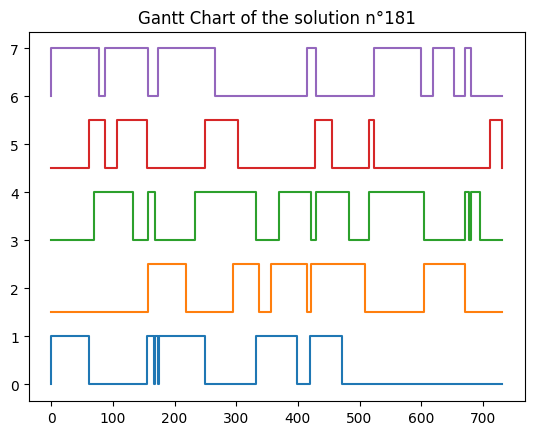

Makespan of the solution n°181 : 731
Regularity of the solution n°181 : 3412
Objective function of the solution n°181 : 2494172


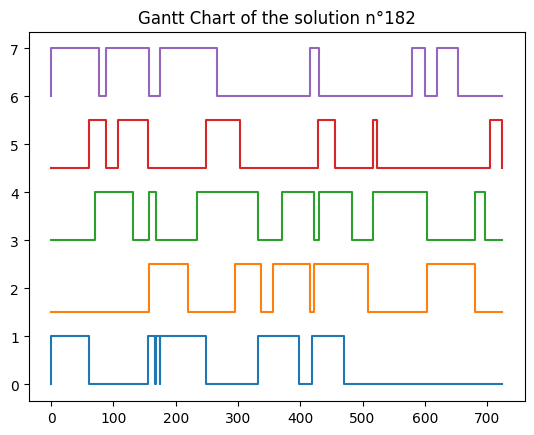

Makespan of the solution n°182 : 724
Regularity of the solution n°182 : 3420
Objective function of the solution n°182 : 2476080


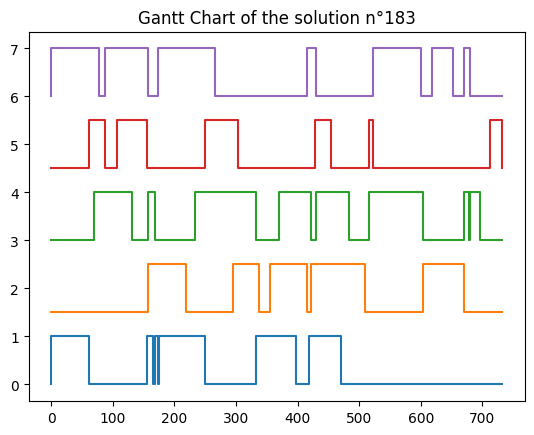

Makespan of the solution n°183 : 732
Regularity of the solution n°183 : 3416
Objective function of the solution n°183 : 2500512


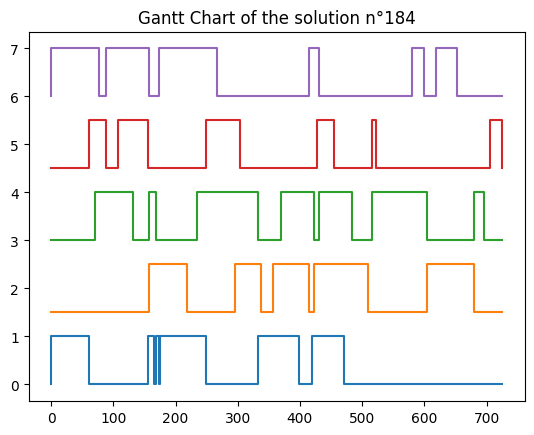

Makespan of the solution n°184 : 725
Regularity of the solution n°184 : 3424
Objective function of the solution n°184 : 2482400


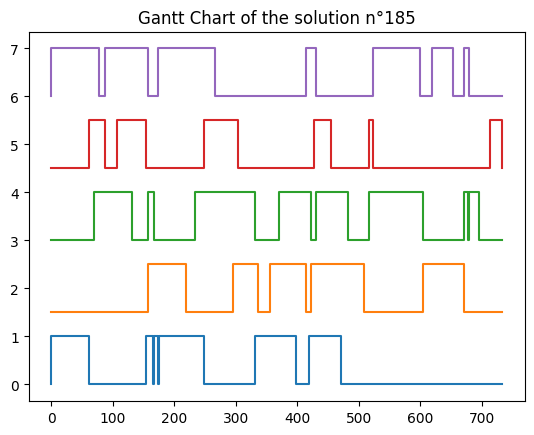

Makespan of the solution n°185 : 733
Regularity of the solution n°185 : 3420
Objective function of the solution n°185 : 2506860


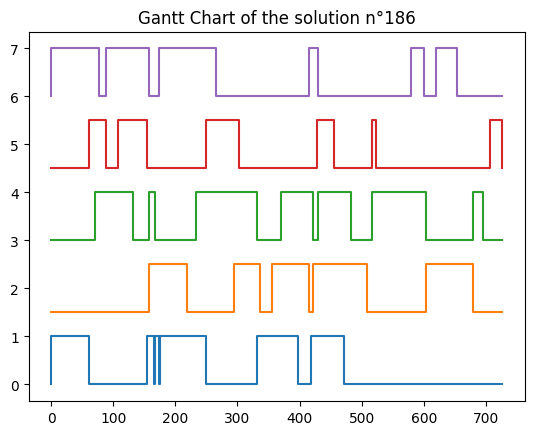

Makespan of the solution n°186 : 726
Regularity of the solution n°186 : 3428
Objective function of the solution n°186 : 2488728


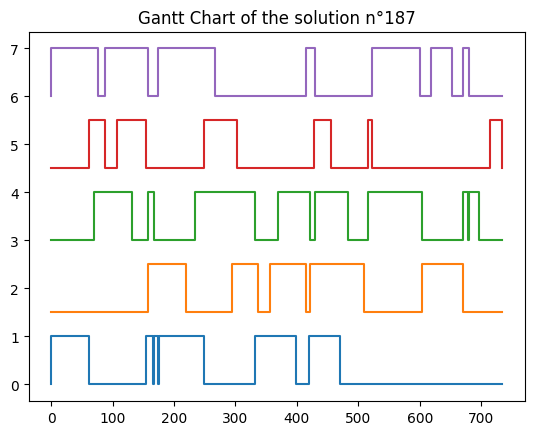

Makespan of the solution n°187 : 734
Regularity of the solution n°187 : 3424
Objective function of the solution n°187 : 2513216


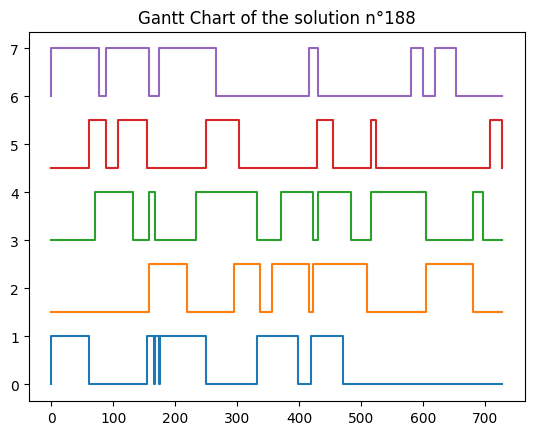

Makespan of the solution n°188 : 727
Regularity of the solution n°188 : 3432
Objective function of the solution n°188 : 2495064


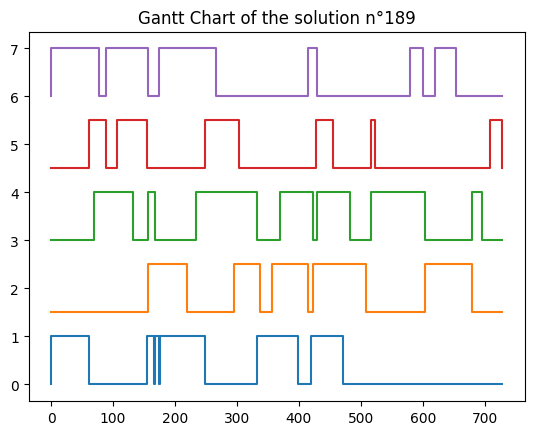

Makespan of the solution n°189 : 728
Regularity of the solution n°189 : 3436
Objective function of the solution n°189 : 2501408


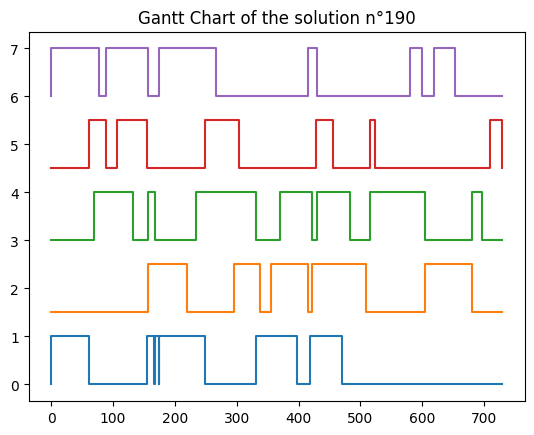

Makespan of the solution n°190 : 729
Regularity of the solution n°190 : 3440
Objective function of the solution n°190 : 2507760


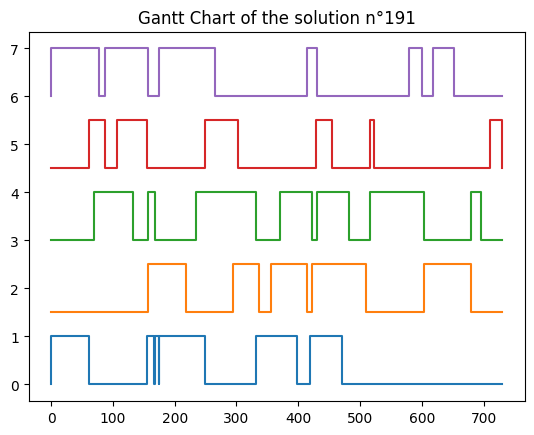

Makespan of the solution n°191 : 730
Regularity of the solution n°191 : 3444
Objective function of the solution n°191 : 2514120


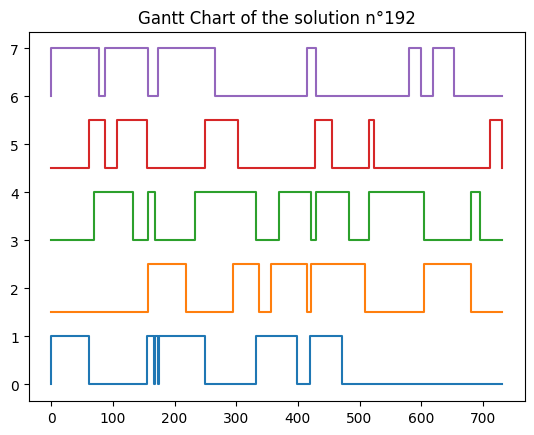

Makespan of the solution n°192 : 731
Regularity of the solution n°192 : 3448
Objective function of the solution n°192 : 2520488


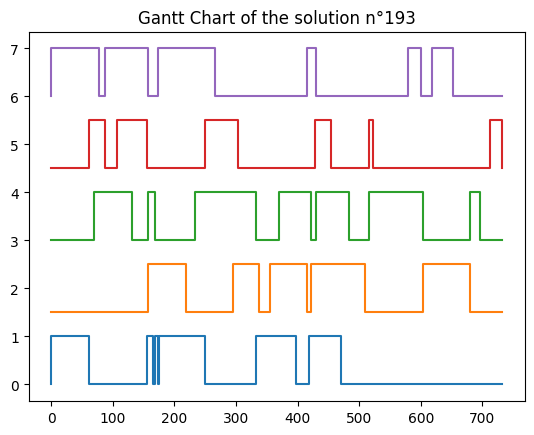

Makespan of the solution n°193 : 732
Regularity of the solution n°193 : 3452
Objective function of the solution n°193 : 2526864


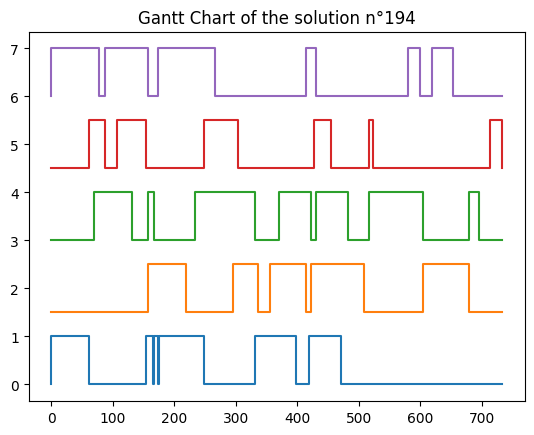

Makespan of the solution n°194 : 733
Regularity of the solution n°194 : 3456
Objective function of the solution n°194 : 2533248


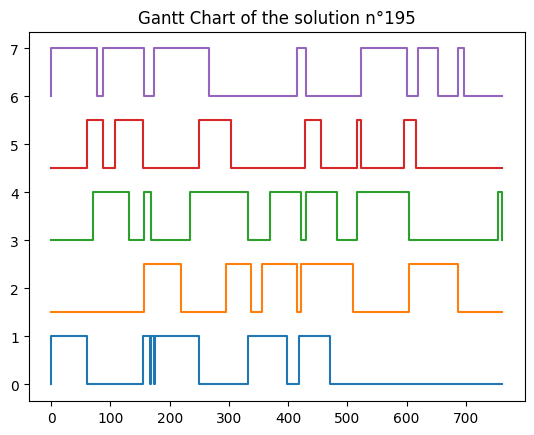

Makespan of the solution n°195 : 761
Regularity of the solution n°195 : 3432
Objective function of the solution n°195 : 2611752


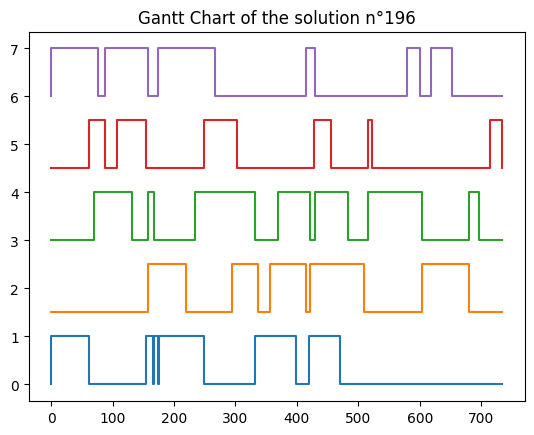

Makespan of the solution n°196 : 734
Regularity of the solution n°196 : 3460
Objective function of the solution n°196 : 2539640


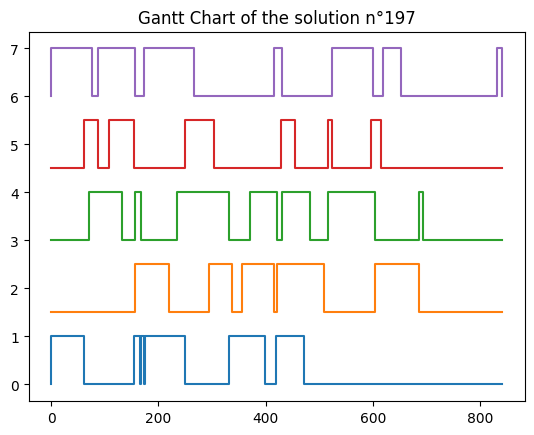

Makespan of the solution n°197 : 841
Regularity of the solution n°197 : 3548
Objective function of the solution n°197 : 2983868


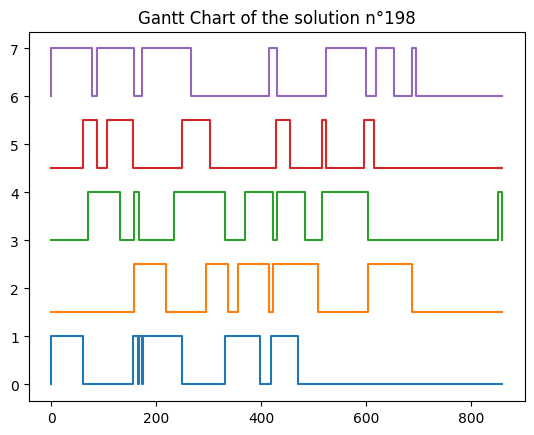

Makespan of the solution n°198 : 859
Regularity of the solution n°198 : 3824
Objective function of the solution n°198 : 3284816


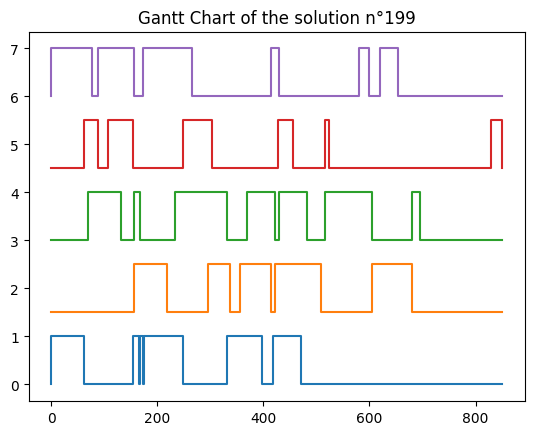

Makespan of the solution n°199 : 850
Regularity of the solution n°199 : 3924
Objective function of the solution n°199 : 3335400


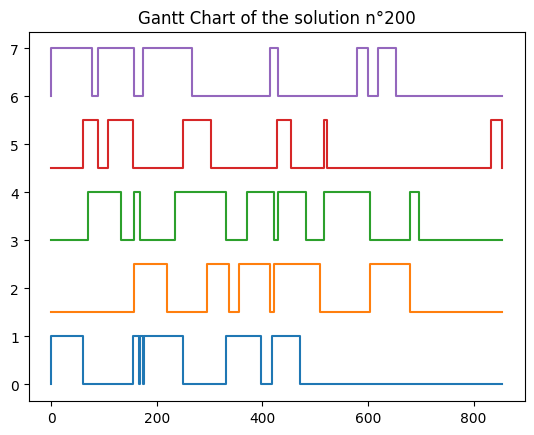

Makespan of the solution n°200 : 854
Regularity of the solution n°200 : 3940
Objective function of the solution n°200 : 3364760


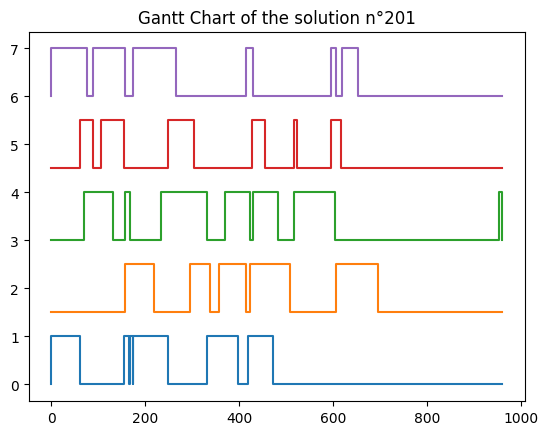

Makespan of the solution n°201 : 959
Regularity of the solution n°201 : 4224
Objective function of the solution n°201 : 4050816


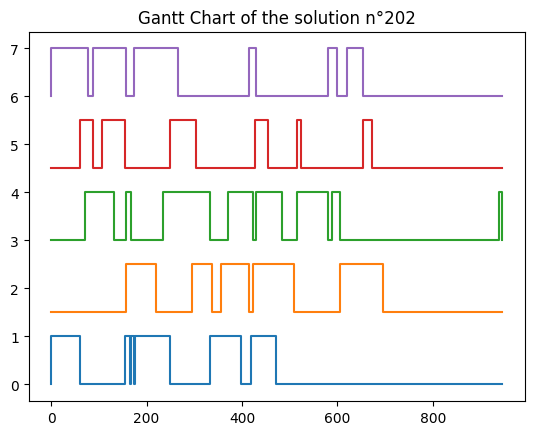

Makespan of the solution n°202 : 945
Regularity of the solution n°202 : 4248
Objective function of the solution n°202 : 4014360


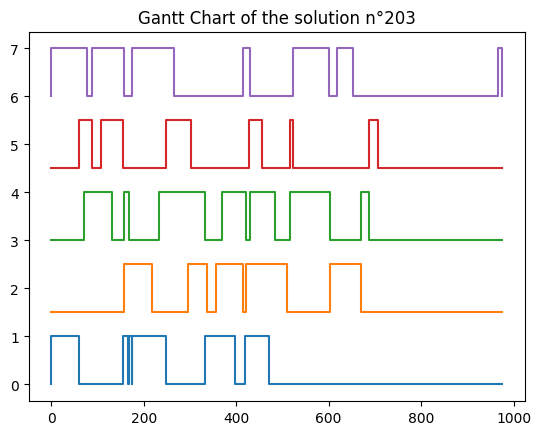

Makespan of the solution n°203 : 975
Regularity of the solution n°203 : 4236
Objective function of the solution n°203 : 4130100


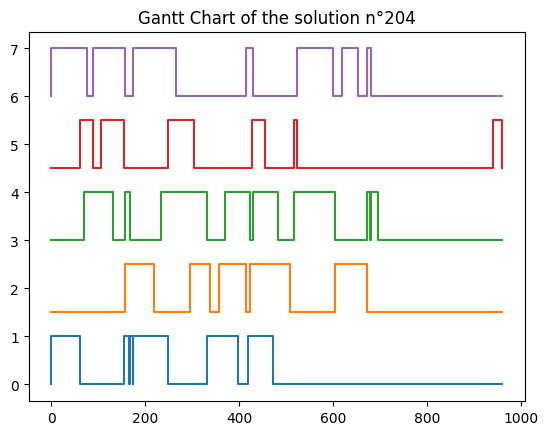

Makespan of the solution n°204 : 959
Regularity of the solution n°204 : 4324
Objective function of the solution n°204 : 4146716


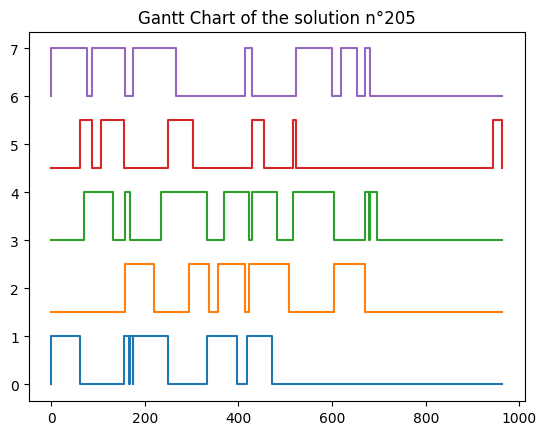

Makespan of the solution n°205 : 963
Regularity of the solution n°205 : 4340
Objective function of the solution n°205 : 4179420


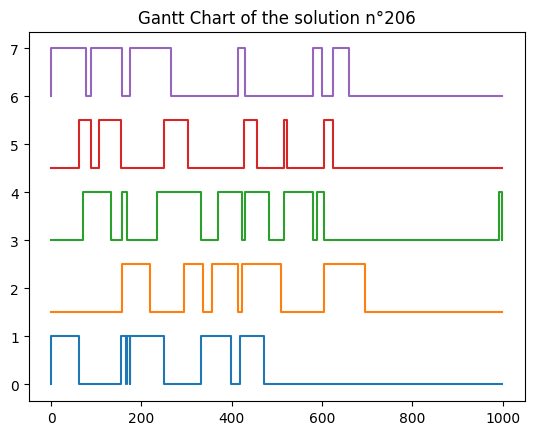

Makespan of the solution n°206 : 999
Regularity of the solution n°206 : 4408
Objective function of the solution n°206 : 4403592


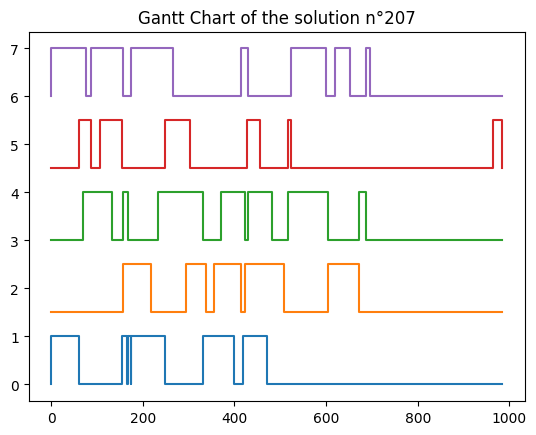

Makespan of the solution n°207 : 984
Regularity of the solution n°207 : 4424
Objective function of the solution n°207 : 4353216


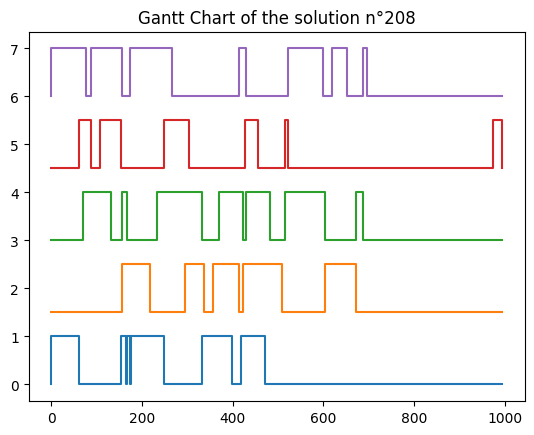

Makespan of the solution n°208 : 994
Regularity of the solution n°208 : 4464
Objective function of the solution n°208 : 4437216


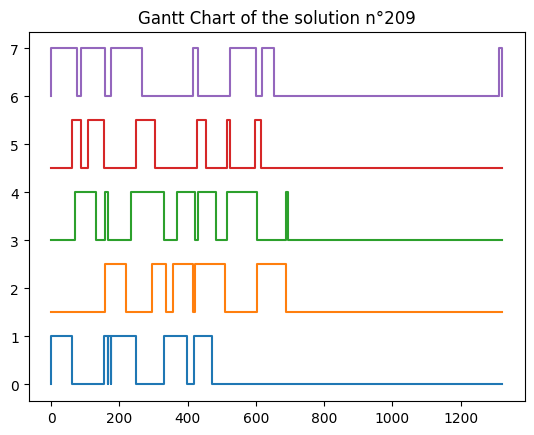

Makespan of the solution n°209 : 1321
Regularity of the solution n°209 : 5468
Objective function of the solution n°209 : 7223228


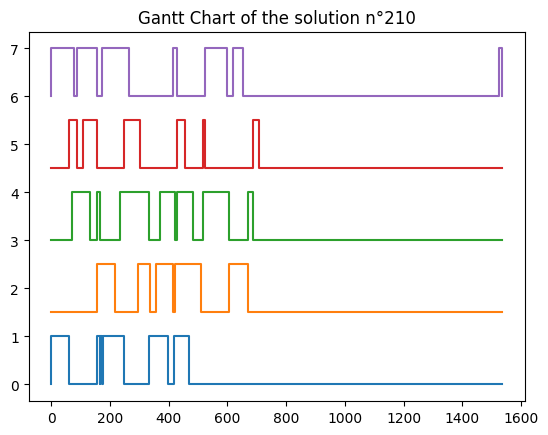

Makespan of the solution n°210 : 1535
Regularity of the solution n°210 : 6476
Objective function of the solution n°210 : 9940660


In [9]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m)))